# Capstone project by Sven Heyer 

# Stock Closing Price Prediction for IBM using Machine Learning Techniques with (non-)return based features

## 1) The problem

**Context and problem statement**:

Predicting stock prices can be a challenging task due to the fact that it depends on various factors like political conditions, global economy, company’s financial reports and performance among others. In addition behavioural finance and other psychological factors (e.g. panic selling) need to be taken into account. Latter are very hard to measure and will not be part of this project.

By now research has stepped heavy into predicting stock closing prices for publicly traded stocks. However it seems that most of the projects have used especially return-based data of the stock to feed their machine learing models. Studies can be extended and pushed further by improving the features engineering and selection part. The conclusion and future scope of some papers suggest to include non-financial data as well as additional financial data (like financial statements) in order to obtain higher accuracy. This project is going to address exactly this problem of untapped potential resulting in a higher model performance. 

**Story**:

I will feed additional (non-)return based data to train machine learning models and apply feature extension as well as engineering techniques based on domain knowledge. The goal is that the machine learning algorithms will outperform the naive baseline model trained with simply return-based feature data. The caveat is that I am NOT going to compare the performance of my project with preceeding studies/researches. The ultimate goal is NOT to build the most predictive model but to show that additional non-return based data can improve the performance of a model.

## 2) The data

### (a) Clear overview of your data

Target objective (to be predicted by the model)
- IBM stock price related data: 

https://finance.yahoo.com/quote/IBM/history?period1=978307200&period2=1628467200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

New feature: overall index for the technology industry
- Dow Jones US Technology index (is designed to measure the stock performance of U.S. companies in the technology industry):

https://www.onvista.de/index/DOW-JONES-US-TECHNOLOGY-PRICE-MS-Index-1244982

New features: Training a model for a single stock might lead to overfitting due the low amount of data available per stock (~250 data points per year per stock). Further economic data influencing the stock price have to be added:
- "Federal Reserve Economic Data" or FRED is a project by the Economic Research department of the Federal Reserve Bank of St Louis. FRED collects over 200,000 US and international economic time series, from 69 different sources, on a single website. Data coverage includes all major areas of macroeconomic analysis: growth, inflation, employment, interest rates, exchange rates, production and consumption, income and expenditure, savings and investment, and more.

https://www.quandl.com/data/FRED-Federal-Reserve-Economic-Data/documentation

New feature: Since the data coming from FRED have a low frequency in most cases, I need to add further data with a daily time index - let's use sector peers of IBM
- Use peers stock prices like Intel, Microsoft, Apple, SAP SE and Oracle for direct competitors performance reference as complementary of Dow Jones US technology index

https://finance.yahoo.com/

- New feature: DOW JONES U.S. OIL & GAS Index for global oil consumption as complementary of FRED with data on a daily basis

https://www.onvista.de/index/DOW-JONES-U-S-OIL-GAS-Index-1197280

- New feature: gold price as "save haven" for economic distress periods reference

https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM

Considerations:

- The training data has to represent the population accordingly and not be one-sided (meaning in this case having upwards and downward trends have to be included). According to the IBM stock chart a representative date range seems from 2010 to 2020 as shown in the EDA below
- Only the day-wise closing price of the stock has been extracted
- Each day for the respective stock will be one row in the training data
- Target date = the following day


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
%matplotlib inline

I use the IBM stock price from Jan 2010 to Jan 2020 in order to capture adequate situations of bear and bull market movements. The same date range have to be used for the other data sets.

In [2]:
# stock price

IBM = pd.read_csv('IBM.csv', index_col='Date')
IBM = IBM.add_prefix('IBM_')

In [3]:
# Drop adjusted close since there has been no stock split and the IBM dividend will be accounted in a separate column
IBM = IBM.drop('IBM_Adj Close', axis = 1)

In [4]:
IBM.head()

IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume
Date                                                          
2001-01-02   84.5000   87.5000  84.1250    84.8125     8007200
2001-01-03   83.7500   95.0000  83.7500    94.6250    12769900
2001-01-04   94.7500   99.7500  92.6875    93.1875    15420500
2001-01-05   93.9375   94.6875  91.0000    94.0000     8043200
2001-01-08   93.5000   93.9375  91.5625    93.5625     6064800

In [5]:
IBM.tail()

IBM_Open    IBM_High     IBM_Low   IBM_Close  IBM_Volume
Date                                                                  
2021-08-02  141.449997  143.059998  141.029999  141.419998     2929500
2021-08-03  141.899994  144.699997  141.649994  144.070007     4084700
2021-08-04  143.800003  144.179993  142.470001  142.759995     2830100
2021-08-05  143.029999  143.410004  142.220001  142.770004     2757400
2021-08-06  143.000000  144.389999  142.889999  144.089996     3822600

- Open and Close (adjusted for splits) represent the starting and final price at which the stock is traded on a particular day
- High, Low and Last represent the maximum, minimum, and last price of the share for the day
- Volume is the number of shares bought or sold in the day 

In [6]:
# stock dividends (the payout date of dividends influence the underlying stock immediately)

IBM_div = pd.read_csv('IBM_dividends.csv', index_col='Date')

In [7]:
IBM_div.head()

Dividends
Date                 
2006-08-08       0.30
2001-11-07       0.14
2002-05-08       0.15
2006-02-08       0.20
2010-08-06       0.65

In [8]:
IBM_div.sort_index(inplace=True)

Competitors closing prices:

In [9]:
Apple = pd.read_csv('AAPL.csv', index_col='Date', usecols=['Date','Close'])

In [10]:
Intel = pd.read_csv('INTC.csv', index_col='Date', usecols=['Date','Close'])

In [11]:
Microsoft = pd.read_csv('MSFT.csv', index_col='Date', usecols=['Date','Close'])

In [12]:
Oracle = pd.read_csv('ORCL.csv', index_col='Date', usecols=['Date','Close'])

In [13]:
SAP = pd.read_csv('SAP.csv', index_col='Date', usecols=['Date','Close'])

Gold and Down Jones price/index points:

In [14]:
Gold = pd.read_csv('GOLD.csv', index_col='Date')

In [15]:
Gold.columns = ['Close']
Gold = Gold.add_prefix('Gold_')

In [16]:
DJ = pd.read_csv('Dow Jones U.S. Technology Index.csv', sep='\t', index_col='Date', usecols=['Date','Close'])

In [17]:
DJ.columns = ['Dow_Jones_Close']

In [18]:
Oil_Gas = pd.read_csv('DOW JONES U.S. OIL & GAS Index.csv', sep='\t', index_col='Date', usecols=['Date','Close'])

In [19]:
Oil_Gas.columns = ['Oil_Gas_Close']

In [20]:
start = datetime.datetime(2001,1,1)
end = datetime.datetime(2021,8,9)

Federal Reserve Economic Data: for category one indicator has been selected which should represent the respective category appropriately. Further selection of other economic indicators can be considered for higher accuracy of the model.

In [21]:
# Growth indicator: Gross Domestic Product

GDP = quandl.get("FRED/GDP", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)

# Prices and Inflation indicator: Consumer Price Index for All Urban Consumers (All Items)

CPI = quandl.get("FRED/CPIAUCSL", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)

# Money Supply indicator: St. Louis Adjusted Monetary Base

MBASE = quandl.get("FRED/BASE", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)


# Interest Rates indicator: Effective Federal Funds Rate

IRATE = quandl.get("FRED/DFF", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)


# Employment indicator: Civilian Unemployment Rate

UNRATE = quandl.get("FRED/UNRATE", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)


# Income indicator: Real Median Household Income in the United States

INCOME = quandl.get("FRED/MEHOINUSA672N", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)

# Expenditure indicator: Personal Consumption Expenditures

PCE = quandl.get("FRED/PCE", authtoken="xuqF1Yt48YFRRBo1A6TB", start_date=start, end_date=end)

# copied content from the Udemy course "Python for Finance: Investment Fundamentals & Data Analytics"

In [22]:
FRED = [GDP,CPI,MBASE,IRATE,UNRATE,INCOME,PCE]

In [23]:
for i in FRED:
    print(i.index[0])

2001-01-01 00:00:00
2001-01-01 00:00:00
2001-01-10 00:00:00
2001-01-01 00:00:00
2001-01-01 00:00:00
2001-01-01 00:00:00
2001-01-01 00:00:00


In [24]:
for i in FRED:
    print(i.index[-1])

2021-04-01 00:00:00
2021-07-01 00:00:00
2019-12-18 00:00:00
2021-08-09 00:00:00
2021-07-01 00:00:00
2019-01-01 00:00:00
2021-06-01 00:00:00


In [25]:
for i in FRED:
    print(i.head(2))

                Value
Date                 
2001-01-01  10470.231
2001-04-01  10599.000
            Value
Date             
2001-01-01  175.6
2001-02-01  176.0
              Value
Date               
2001-01-10  613.643
2001-01-24  619.075
            Value
Date             
2001-01-01   5.41
2001-01-02   6.67
            Value
Date             
2001-01-01    4.2
2001-02-01    4.2
              Value
Date               
2001-01-01  61126.0
2002-01-01  60435.0
             Value
Date              
2001-01-01  6987.4
2001-02-01  7001.8


The features have different start/end date values as well as different frequencies. However when concatenating I will fill the gaps with N/A values and clean them afterwards.

In [26]:
FRED_df = pd.concat([GDP,CPI,MBASE,IRATE,UNRATE,INCOME,PCE], axis=1)

In [27]:
FRED_df.columns = ['GDP','CPI','MBASE','IRATE','UNRATE','INCOME','PCE']

In [28]:
peers_df = pd.concat([Apple,Intel,Microsoft,Oracle,SAP], axis=1, sort=False)

In [29]:
peers_df.columns = ['Apple_Close','Intel_Close','Microsoft_Close','Oracle_Close','SAP_Close']

Set appropriate time data index type and concatenate all features including target variable:

In [30]:
DJ.head()

Dow_Jones_Close
Date                        
  01.01.2001          749,01
  02.01.2001          688,43
  04.01.2001          803,53
  05.01.2001          747,22
  06.01.2001          747,22

In [31]:
DJ.reset_index(inplace=True)

In [32]:
DJ.Date = DJ.Date.str.replace('.','-')

In [33]:
DJ.Dow_Jones_Close = DJ.Dow_Jones_Close.str.replace('.','')

In [34]:
DJ.Dow_Jones_Close = DJ.Dow_Jones_Close.str.replace(',','.')

In [35]:
DJ.set_index('Date', inplace=True)

In [36]:
# remove whitespaces on the left side

DJ.index = DJ.index.str.strip()

In [37]:
DJ.index = pd.to_datetime(DJ.index, format='%d-%m-%Y')

In [38]:
DJ.head()

Dow_Jones_Close
Date                      
2001-01-01          749.01
2001-01-02          688.43
2001-01-04          803.53
2001-01-05          747.22
2001-01-06          747.22

In [39]:
Oil_Gas.head()

Oil_Gas_Close
Date                      
  01.01.2001        272,96
  02.01.2001        275,37
  04.01.2001        256,05
  05.01.2001        259,06
  06.01.2001        259,06

In [40]:
Oil_Gas.reset_index(inplace=True)

In [41]:
Oil_Gas.Date = Oil_Gas.Date.str.replace('.','-')

In [42]:
Oil_Gas.Oil_Gas_Close = Oil_Gas.Oil_Gas_Close.str.replace(',','.')

In [43]:
Oil_Gas.set_index('Date', inplace=True)

In [44]:
# remove whitespaces on the left side

Oil_Gas.index = Oil_Gas.index.str.strip()

In [45]:
Oil_Gas.index = pd.to_datetime(Oil_Gas.index, format='%d-%m-%Y')

In [46]:
Oil_Gas.head()

Oil_Gas_Close
Date                    
2001-01-01        272.96
2001-01-02        275.37
2001-01-04        256.05
2001-01-05        259.06
2001-01-06        259.06

In [47]:
for i in IBM, IBM_div, Gold, FRED_df, peers_df:
    i.index = pd.to_datetime(i.index, format='%Y-%m-%d')

In [48]:
# drop duplicates from Oil_Gas in order to prevent error (NA will be filled later)

df = pd.concat([IBM, IBM_div, Gold, DJ, Oil_Gas.drop_duplicates(), FRED_df, peers_df], axis=1)

In [49]:
df.head()

IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  Dividends  \
2001-01-01       NaN       NaN      NaN        NaN         NaN        NaN   
2001-01-02   84.5000   87.5000  84.1250    84.8125   8007200.0        NaN   
2001-01-03   83.7500   95.0000  83.7500    94.6250  12769900.0        NaN   
2001-01-04   94.7500   99.7500  92.6875    93.1875  15420500.0        NaN   
2001-01-05   93.9375   94.6875  91.0000    94.0000   8043200.0        NaN   

           Gold_Close Dow_Jones_Close Oil_Gas_Close        GDP  ...  MBASE  \
2001-01-01        NaN          749.01        272.96  10470.231  ...    NaN   
2001-01-02    272.800          688.43        275.37        NaN  ...    NaN   
2001-01-03    269.000             NaN           NaN        NaN  ...    NaN   
2001-01-04    268.750          803.53        256.05        NaN  ...    NaN   
2001-01-05    268.000          747.22        259.06        NaN  ...    NaN   

            IRATE  UNRATE   INCOME     PCE  Apple_Close  Intel_Close  \
2001-01-01   5.41     4.2  61126.0  6987.4          NaN          NaN   
2001-01-02   6.67     NaN      NaN     NaN     0.265625    31.062500   
2001-01-03   6.35     NaN      NaN     NaN     0.292411    34.234375   
2001-01-04   5.92     NaN      NaN     NaN     0.304688    33.796875   
2001-01-05   5.83     NaN      NaN     NaN     0.292411    32.062500   

            Microsoft_Close  Oracle_Close  SAP_Close  
2001-01-01              NaN           NaN        NaN  
2001-01-02         21.68750       26.3750    30.3125  
2001-01-03         23.96875       32.0000    35.7500  
2001-01-04         24.21875       32.5625    29.8125  
2001-01-05         24.56250       30.1250    29.2500  

[5 rows x 21 columns]

### (b) Plan to manage and process the data

I will manage my data by saving them into csv files or loading directly from web databases using API (see Quandl). The plan for data cleaning and manipulation involves the following steps:

Find and handle incorrect, missing values:
- Observations related to weekend days will be removed since stock prices and other indicators are not traded or not published/amended during weekends 
- Plan to harmonize frequencies of features: the missing values of features with frequency less than 'Daily' will be replaced by the mean of the precessing and processing value (e.g. take value of 1st quarter and 2nd quarter to compute the average and fill in the NaN in between first and second quarter). 

Correct inconsistencies in the variables:
- The fractional part of floating values will be reduced to two values (e.g. 12.45 instead of 12.450223)
- Dow Jones includes comma separated digits
- Update column dtypes for consistency (float64 only)


Handle outliers:
- For stock prices, gold and index: I will use 'detect_outliers_rolling' definition from the EPFL course to detect a change in behavior compared to the preceding window (center=False)
- For remaining features: 
    - if the distribution is not skewed: apply z-score technique
    - if the features seem to be skewed I have to apply log-transformations before the outliers will be spotted and the outliers have to be removed based on IQR technique

Feature engineering: all features will be calculated by myself

- I will use some of the following return-based **technical indicators** in order to capture momentum effects: 
    - Stock High minus Low price (H-L)
    - Stock Close minus Open price (O-C)
    - Stock price’s seven days’ moving average (7 DAYS MA)
    - Stock price’s fourteen days’ moving average (14 DAYS MA)
    - Stock price’s twenty one days’ moving average (21 DAYS MA)
    - Stock price’s standard deviation for the past seven days (7 DAYS STD DEV)
    - Stock price’s 52 days low/high (52 DAYS L/H)
    - For reference: https://www.visualcapitalist.com/12-types-technical-indicators-stocks/
   
   
- I can add our own set of features that I believe would be relevant for the predictions. For instance, my hypothesis is that the **first and last days of the week** could potentially affect the closing price of the stock far more than the other days. So I will create a feature that identifies whether a given day is Monday/Friday or Tuesday/Wednesday/Thursday in case the EDA supports my assumption. In addition I will check for months, quarters and years as well.


- Highlight **high/low important periods** for company specific events like performance reporting (quarterly), "Sell in may, go away", Christmas tim etc.


- **Dividend** feature will be one-hot-encoded because the dvidend payment date is impacting the close price immediately


- **Sharpe Ratio**: mean of the daily returns divided by the standard deviation of the daily returns since the interest rates are so low, it is commonly assumed that the risk free rate is zero

I plan to combine the different data sets with first transforming them to the same index dtype (datetime64 in this case). The compatibility of the different data sets in terms of different units (frequency of datetime per rows is varying between the data sets) is set to a daily index representation from January 2010 to January 2021. By using the concatenation function appropriately all featrues concatenated will have a daily index in the final dataframe. I'm planning to use all features from the imported data sets (except for adj. close). Since all features are numerical no feature encoding is required.

---

Handle incorrect values and datatypes:

In [50]:
df.loc[:,'Gold_Close'] = df.loc[:,'Gold_Close'].replace('.', np.nan, inplace=False)

In [51]:
df.loc[:,'Gold_Close'] = df.loc[:,'Gold_Close'].astype('float64')

In [52]:
df.loc[:,'Dow_Jones_Close'] = df.loc[:,'Dow_Jones_Close'].astype('float64')

In [53]:
df.loc[:,'Oil_Gas_Close'] = df.loc[:,'Oil_Gas_Close'].astype('float64')

First replace missing values for features with frequency less than Daily. Then remove the weekend days if no dividend has been redeemed on such a day. This approach will prevent removing very rare information for features with low frequencies.

Let's have a look at the frequencies of each FRED variables:

In [54]:
for x in FRED_df.columns:
    print(x,FRED_df[x][FRED_df[x].notnull()].count())

GDP 82
CPI 247
MBASE 495
IRATE 7526
UNRATE 247
INCOME 19
PCE 246


The INCOME variable has the lowest frequency (yearly basis since we are looking at a date range of 10 years). Now the missing values will be addressed as outlined in the plan:

In [55]:
for x in FRED_df.columns:
    
    enum = np.arange(0,df[x][df[x].notnull()].count()-1)
    enum_ind = df[x][df[x].notnull()].index
    
    for i in enum:
        df[x].loc[enum_ind[i] + pd.DateOffset(days=+1): enum_ind[i+1] + pd.DateOffset(days=-1)].replace(np.nan, np.mean(df[x][enum_ind[i]:enum_ind[i+1]]), inplace=True)

print(df[FRED_df.columns].isnull().sum())

# print(df.PCE['2010-01-01':'2010-03-01'])   

GDP       131
CPI        40
MBASE     610
IRATE       1
UNRATE     40
INCOME    952
PCE        70
dtype: int64


MBASE and INCOME still have some NaN values. I will replace them with the first non-null value in the head and with the last non-null value in the tail:

In [56]:
for x in FRED_df.columns:
    
    df[x] = df[x].fillna(method='bfill')
    df[x] = df[x].fillna(method='ffill')

In [57]:
df[FRED_df.columns].isnull().sum()

GDP       0
CPI       0
MBASE     0
IRATE     0
UNRATE    0
INCOME    0
PCE       0
dtype: int64

In [58]:
df.Oil_Gas_Close = df.Oil_Gas_Close.fillna(method='bfill')

In [59]:
df.isnull().sum()

IBM_Open           2345
IBM_High           2345
IBM_Low            2345
IBM_Close          2345
IBM_Volume         2345
Dividends          7445
Gold_Close         2322
Dow_Jones_Close    2064
Oil_Gas_Close         0
GDP                   0
CPI                   0
MBASE                 0
IRATE                 0
UNRATE                0
INCOME                0
PCE                   0
Apple_Close        2345
Intel_Close        2344
Microsoft_Close    2344
Oracle_Close       2344
SAP_Close          2344
dtype: int64

Now a rather steady and clear trend curve has been created instead of low frequency values with lot of gaps:

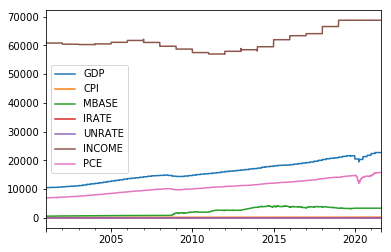

In [60]:
df[FRED_df.columns].plot()
plt.show()

In [61]:
df.Dividends[df.IBM_Close.isnull()].value_counts().sum()

0

Indeed I can remove the weekend days without losing relevant information from the Dividend column

In [62]:
df.shape

(7527, 21)

Drop the weekends:

In [63]:
df = df[df.index.dayofweek < 5]

In [64]:
df.isnull().sum()

IBM_Open            195
IBM_High            195
IBM_Low             195
IBM_Close           195
IBM_Volume          195
Dividends          5295
Gold_Close          172
Dow_Jones_Close     187
Oil_Gas_Close         0
GDP                   0
CPI                   0
MBASE                 0
IRATE                 0
UNRATE                0
INCOME                0
PCE                   0
Apple_Close         195
Intel_Close         194
Microsoft_Close     194
Oracle_Close        194
SAP_Close           194
dtype: int64

Since I have only dropped weekends the data set still includes null values due to public and bank holidays. I will simply fill them with the value from the previous day. The dividend columns will be handled during the feature engineering process.

In [65]:
for x in df.drop('Dividends', axis=1).columns:
    
    df[x] = df[x].fillna(method='bfill')
    df[x] = df[x].fillna(method='ffill')

In [66]:
df.isnull().sum()

IBM_Open              0
IBM_High              0
IBM_Low               0
IBM_Close             0
IBM_Volume            0
Dividends          5295
Gold_Close            0
Dow_Jones_Close       0
Oil_Gas_Close         0
GDP                   0
CPI                   0
MBASE                 0
IRATE                 0
UNRATE                0
INCOME                0
PCE                   0
Apple_Close           0
Intel_Close           0
Microsoft_Close       0
Oracle_Close          0
SAP_Close             0
dtype: int64

## 3) Exploratory data analysis (EDA)

In [67]:
df.describe().apply(lambda s: s.apply('{0:.1f}'.format)).transpose().loc['IBM_Close':][['mean', 'std', 'min', '25%', '75%', 'max']]

mean        std        min        25%        75%  \
IBM_Close            130.3       37.7       55.1       95.4      158.3   
IBM_Volume       5995094.0  3302384.9  1027500.0  3793200.0  7231000.0   
Dividends              0.8        0.5        0.1        0.2        1.4   
Gold_Close          1033.0      486.1      256.7      556.6     1339.5   
Dow_Jones_Close     1016.8      797.7      253.6      513.5     1129.8   
Oil_Gas_Close        484.7      161.4      176.2      361.5      610.2   
GDP                16081.6     3408.0    10470.2    13676.3    18693.5   
CPI                  221.3       26.0      175.6      199.6      240.2   
MBASE               2263.1     1302.1      613.6      832.6     3498.4   
IRATE                  1.5        1.6        0.0        0.1        2.1   
UNRATE                 6.1        1.9        3.5        4.7        7.3   
INCOME             61589.5     3479.8    56966.5    59494.0    63329.5   
PCE                10853.6     2329.1     6987.4     9114.5    12663.0   
Apple_Close           22.9       30.4        0.2        2.3       29.7   
Intel_Close           30.2       12.2       12.1       21.3       34.9   
Microsoft_Close       55.9       54.6       15.2       26.7       55.2   
Oracle_Close          30.6       16.3        7.3       15.9       41.6   
SAP_Close             67.7       33.2       10.1       42.9       82.8   

                        max  
IBM_Close             215.8  
IBM_Volume       41207300.0  
Dividends               1.6  
Gold_Close           2061.5  
Dow_Jones_Close      4341.0  
Oil_Gas_Close         855.7  
GDP                 22722.6  
CPI                   272.3  
MBASE                4167.8  
IRATE                   6.7  
UNRATE                 14.8  
INCOME              68703.0  
PCE                 15771.6  
Apple_Close           149.1  
Intel_Close            68.5  
Microsoft_Close       289.7  
Oracle_Close           90.7  
SAP_Close             169.0

- No negative values detected
- At first sight the feature IBM_Volume might include outliers since the max is six times higher than the 75% quantile
- I have to apply bollinger bands in order to spot outliers for the stock prices

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5377 entries, 2001-01-01 to 2021-08-10
Data columns (total 21 columns):
IBM_Open           5377 non-null float64
IBM_High           5377 non-null float64
IBM_Low            5377 non-null float64
IBM_Close          5377 non-null float64
IBM_Volume         5377 non-null float64
Dividends          82 non-null float64
Gold_Close         5377 non-null float64
Dow_Jones_Close    5377 non-null float64
Oil_Gas_Close      5377 non-null float64
GDP                5377 non-null float64
CPI                5377 non-null float64
MBASE              5377 non-null float64
IRATE              5377 non-null float64
UNRATE             5377 non-null float64
INCOME             5377 non-null float64
PCE                5377 non-null float64
Apple_Close        5377 non-null float64
Intel_Close        5377 non-null float64
Microsoft_Close    5377 non-null float64
Oracle_Close       5377 non-null float64
SAP_Close          5377 non-null float64
dtypes: float64(

- Number of features: 21 
- Number of observations: 7527 (will be reduced during data cleaning process)
- The features are all encoded as numerical variables 
- Lots of missing data due to the following reasons: stock prices are not traded on weekends/public holidays. FRED related features have a low frequency in most cases.

C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


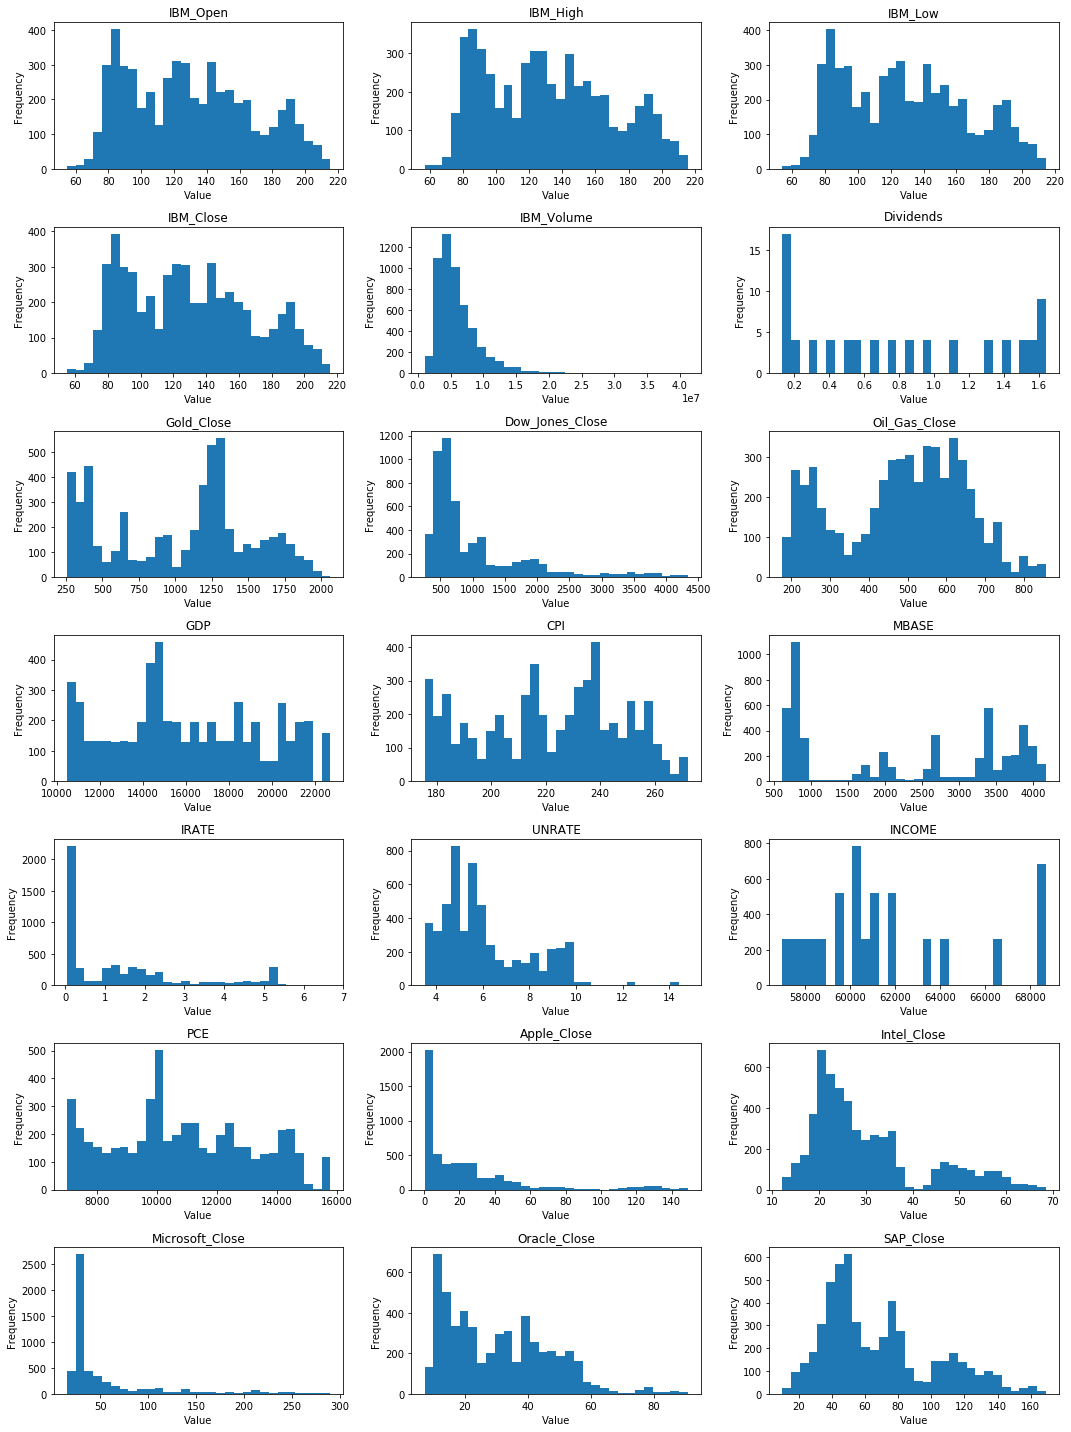

In [69]:
# A quick look at the distribution of the variables

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

for c, ax in zip(df.columns, axes.ravel()):
    ax.hist(df[c], bins=30)
    ax.set_title(c)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')

plt.tight_layout() 
plt.show()

Some features tend to have a skewed distribution like Oracle. Let's see if we can fix this with a log-transformation.

In [70]:
l = [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

In [71]:
i = [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6]

In [72]:
comb = zip(i,l)

Let's have a look at the boxplots **after log-transformation** of all variables:

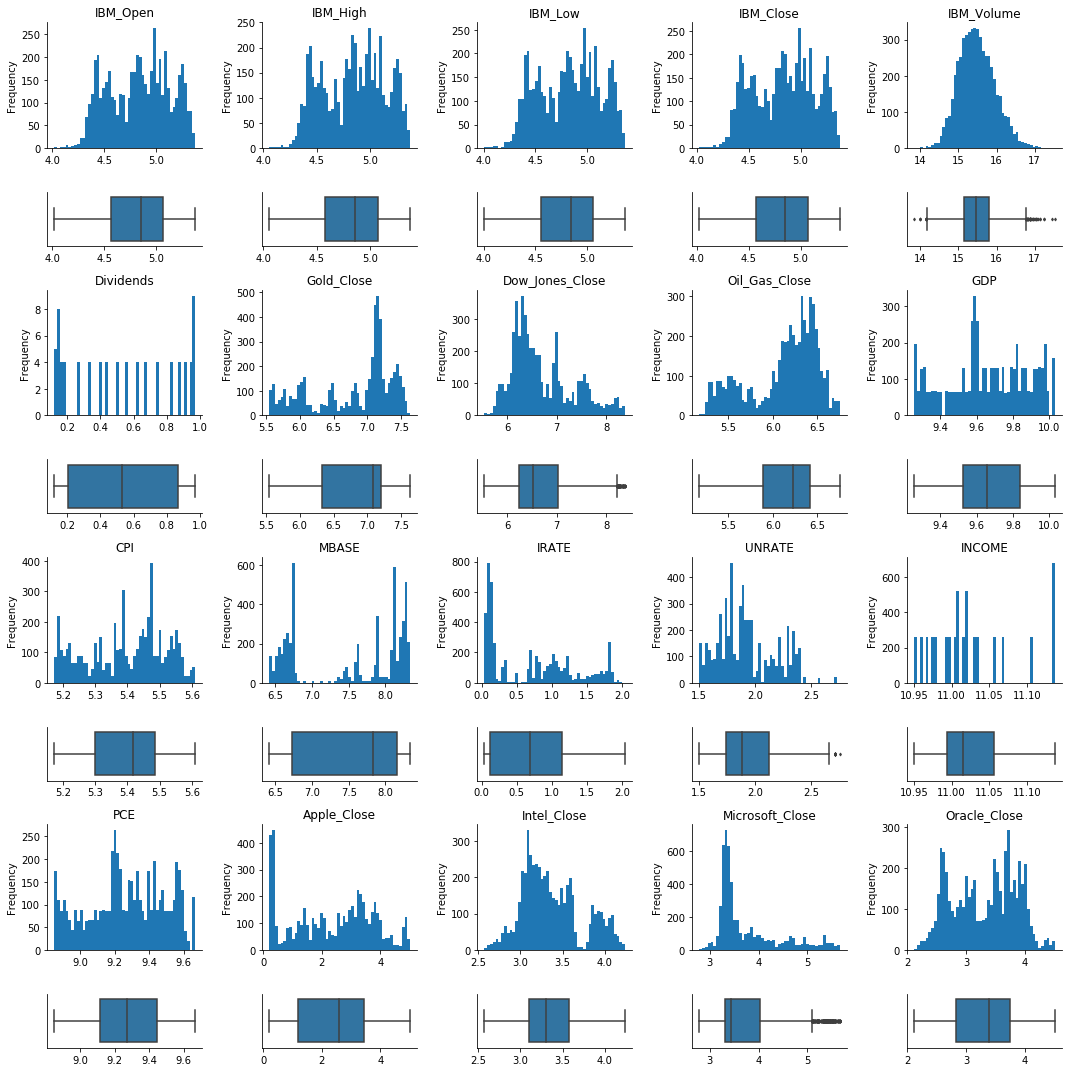

In [73]:
fig, axes = plt.subplots(
    8, 5, gridspec_kw={"height_ratios": (0.7, 0.3,0.7, 0.3,0.7, 0.3,0.7, 0.3)}, figsize=(15, 15)
)

for (feat, plot_col) in zip(
    df.columns, l  # pairing feature with column in plot
):
    ind = next(comb)
    
    axes[ind[0], plot_col].hist(np.log1p(df[feat]), bins=50)
    axes[ind[0], plot_col].set_title("{}".format(feat))
    axes[ind[0], plot_col].set_ylabel('Frequency')
    sns.despine(ax=axes[ind[0], plot_col])
    sns.boxplot(np.log1p(df[feat]), ax=axes[ind[0]+1, plot_col], fliersize=2)
    axes[ind[0]+1, plot_col].set(yticks=[])
    sns.despine(ax=axes[ind[0]+1, plot_col], left=False)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

Indeed the histogram of Oracle has a shape rather looking like a normal distribution now. I have to be careful while interpreting the output. For example the stock price boxplots could indicate outliers but is not really suitable for time series data due to non-stationarity (see particular section below). However since my **target** will not be the absolute price of IBM but the **relative** price change of IBM I strongly assume that the distributions will change towards a normal distribution. If this is the case there is no need for a log-transformation. Skip to the section 'Target (output-factor)' if you need more details at this point.

----

#### FRED features (macro-factors)

Let's have a look at the frequencies of features:

In [74]:
for x in df.columns:
    print(x,df[x][df[x].notnull()].count())

IBM_Open 5377
IBM_High 5377
IBM_Low 5377
IBM_Close 5377
IBM_Volume 5377
Dividends 82
Gold_Close 5377
Dow_Jones_Close 5377
Oil_Gas_Close 5377
GDP 5377
CPI 5377
MBASE 5377
IRATE 5377
UNRATE 5377
INCOME 5377
PCE 5377
Apple_Close 5377
Intel_Close 5377
Microsoft_Close 5377
Oracle_Close 5377
SAP_Close 5377


The higher the number the higher the frequency. Income has the lowest frequency since the data is published on a yearly basis only.

In [75]:
# check for FRED_df where no handling of missing values has been applied

for x in FRED_df.columns:
    print(x,FRED_df[x][FRED_df[x].notnull()].count())

GDP 82
CPI 247
MBASE 495
IRATE 7526
UNRATE 247
INCOME 19
PCE 246


In [76]:
FRED_fr = []

for x in FRED_df.columns:
    FRED_fr.append(FRED_df[x][FRED_df[x].notnull()].count())

In [77]:
pd.DataFrame(FRED_fr,FRED_df.columns, columns=['Frequency']).sort_values('Frequency', ascending=False)

Frequency
IRATE        7526
MBASE         495
CPI           247
UNRATE        247
PCE           246
GDP            82
INCOME         19

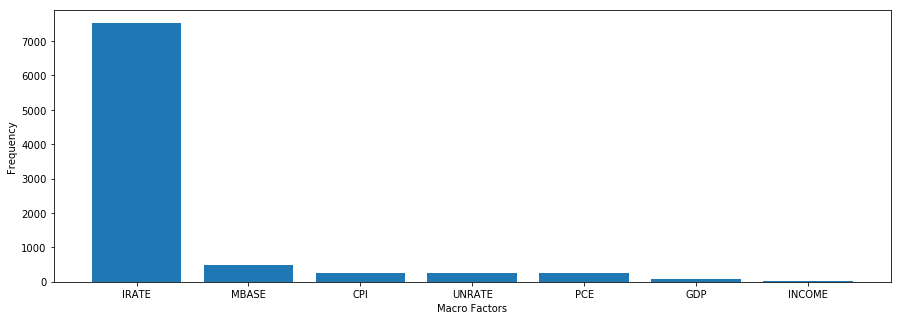

In [78]:
plt.figure(figsize=(15,5))

plt.bar(pd.DataFrame(FRED_fr,FRED_df.columns, columns=['Frequency']).sort_values('Frequency', ascending=False).index, pd.DataFrame(FRED_fr,FRED_df.columns, columns=['Frequency']).sort_values('Frequency', ascending=False).Frequency)
plt.ylabel('Frequency')
plt.xlabel('Macro Factors')
plt.show();

There is not much of a change in the data apart from the interest rate. Unfortunately the FRED features will not provide a lot of information that could be leveraged by an algorithm. Nevertheless I keep them for the moment in my data set because they are supposed to be important based on my knowledge. Maybe some of them will be removed at a later stage.

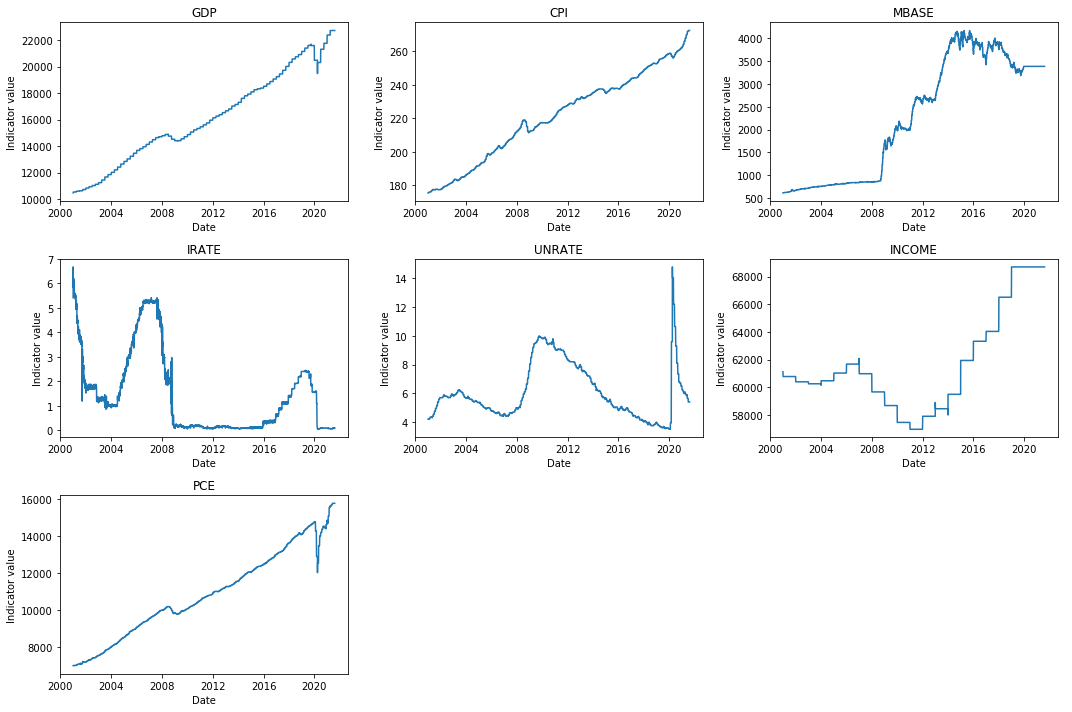

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for column, ax in zip(df[FRED_df.columns], axes.ravel()):
    ax.plot(df[column].dropna())
    ax.set_title(column)
    ax.set_ylabel('Indicator value')
    ax.set_xlabel('Date')
    
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
plt.tight_layout() 
plt.show()

The huge drops in most plots are referring to the financial crisis (2008) and corona crisis (2020). In these scenarios the federal bank typically increase M1 (see MBASE), decrease the interest rate in order to stimulate economic activities (see IRATE), the unemployment explode due to insecure phase (see UNRATE) etc.

The macro factors will be transformed with the pct_change(1) function as shown later in the project. The effect of this transformation on the FRED variables is that this will generate a lot of zeros due to their low frequencies. Although I will fill the missing values upfront most of the newly inserted values will be the same. Since the values do not change a lot the models cannot learn much from them in the end.

Before removing all weekend days, check if they do not include important information (i.e. dividend payment which has a low frequency and was not removed due to encoding later on):

---

#### Index/Gold and peers features (industry-factors)

In [80]:
close_prices = df.loc[:,['Close' in str(x) for x in df.columns]]

As mentioned before my target will be the relative price change of IBM stock prices. This is why I should not compare the absoulte data:

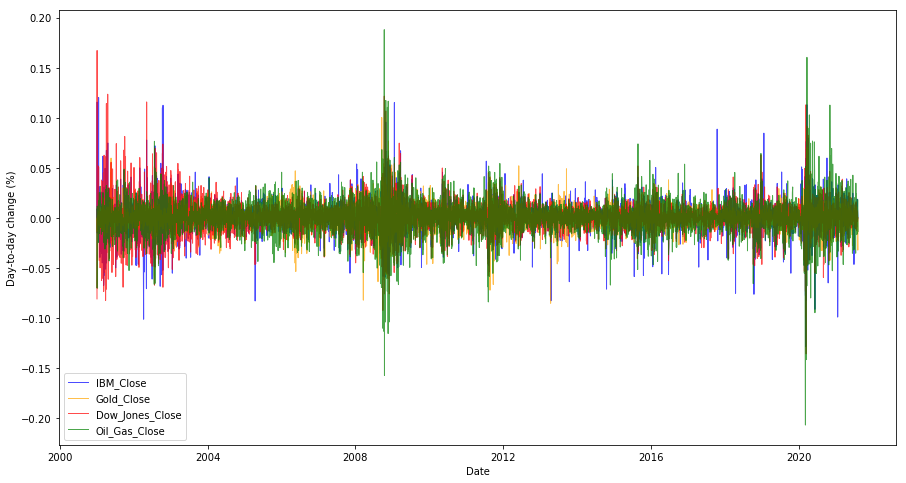

In [81]:
plt.figure(figsize=(15,8))

plt.plot(close_prices.IBM_Close.pct_change(1), marker='', color='blue', linewidth=1, alpha=0.7)

plt.plot(close_prices.Gold_Close.pct_change(1), marker='', color='orange', linewidth=1, alpha=0.7)

plt.plot(close_prices.Dow_Jones_Close.pct_change(1), marker='', color='red', linewidth=1, alpha=0.7)

plt.plot(close_prices.Oil_Gas_Close.pct_change(1), marker='', color='green', linewidth=1, alpha=0.7)

plt.ylabel('Day-to-day change (%)')
plt.xlabel('Date')

plt.legend()
plt.show()

For this section I take a quick look at the **absolute** prices of IBM compared to its index, gold and peers in order to make conclusions:

In [82]:
# close_prices = close_prices.dropna(axis=0)

In [83]:
close_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5377 entries, 2001-01-01 to 2021-08-10
Data columns (total 9 columns):
IBM_Close          5377 non-null float64
Gold_Close         5377 non-null float64
Dow_Jones_Close    5377 non-null float64
Oil_Gas_Close      5377 non-null float64
Apple_Close        5377 non-null float64
Intel_Close        5377 non-null float64
Microsoft_Close    5377 non-null float64
Oracle_Close       5377 non-null float64
SAP_Close          5377 non-null float64
dtypes: float64(9)
memory usage: 420.1 KB


In [84]:
# indexing the stock prices for a better comparability

stock_normed = close_prices/close_prices.iloc[0]

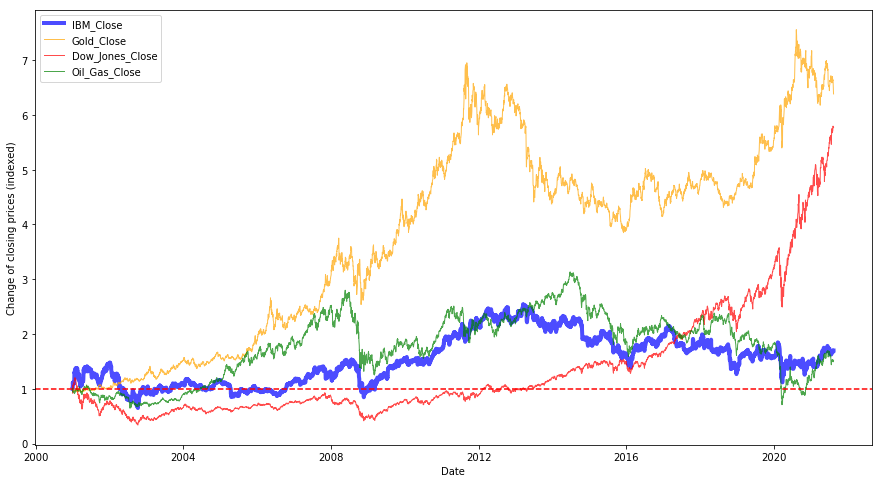

In [85]:
plt.figure(figsize=(15,8))

plt.plot(stock_normed.IBM_Close, marker='', color='blue', linewidth=4, alpha=0.7)

plt.plot(stock_normed.Gold_Close, marker='', color='orange', linewidth=1, alpha=0.7)

plt.plot(stock_normed.Dow_Jones_Close, marker='', color='red', linewidth=1, alpha=0.7)

plt.plot(stock_normed.Oil_Gas_Close, marker='', color='green', linewidth=1, alpha=0.7)


plt.ylabel('Change of closing prices (indexed)')
plt.xlabel('Date')
plt.axhline(y=1, color='r', linestyle="--")
plt.legend()
plt.show()

The reference prices could be seen as indicators of IBM's future price in the short-term. If Gold and oil/gas prices go up or down then IBM follows the same pattern. Gold was going up especially during financial crisis and corona crisis. Dow Jones and IBM had a similar development until mid of 2013 - afterwards a gap occured between them. 

How does the comparison between **peers** and IBM look like?

In [86]:
def show_stock_chart(peers):
    
    plt.figure(figsize=(15,8))

    # plot multiple lines
    for column in stock_normed:
        plt.plot(stock_normed[peers], marker='', color='black', linewidth=4, alpha=0.7)
        plt.annotate(peers,xy=(stock_normed.index[-1],stock_normed.tail(1)[peers]))

    # Now re do the interesting stock IBM, but biger with distinct color
    plt.plot(stock_normed.IBM_Close, marker='', color='blue', linewidth=1, alpha=0.3)
    plt.annotate('IBM_Close',xy=(stock_normed.index[-1],stock_normed.tail(1).IBM_Close))

    plt.plot(stock_normed.Gold_Close, marker='', color='orange', linewidth=1, alpha=0.3)
    plt.annotate('Gold_Close',xy=(stock_normed.index[-1],stock_normed.tail(1).Gold_Close))

    plt.plot(stock_normed.Dow_Jones_Close, marker='', color='red', linewidth=1, alpha=0.3)
    plt.annotate('Dow_Jones_Close',xy=(stock_normed.index[-1],stock_normed.tail(1).Dow_Jones_Close))
    
    plt.plot(stock_normed.Oil_Gas_Close, marker='', color='green', linewidth=1, alpha=0.3)
    plt.annotate('Oil_Gas_Close',xy=(stock_normed.index[-1],stock_normed.tail(1).Oil_Gas_Close))

    
    plt.ylabel('Change of closing prices (indexed)')
    plt.xlabel('Date')
    plt.axhline(y=1, color='r', linestyle="--")
    plt.show()

In [87]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
%load_ext autoreload
%autoreload 2

In [88]:
peers_controls = widgets.interactive(show_stock_chart, 
                                   peers = peers_df.columns)

# copied content from the Coursera course "Investment Management with Python and Machine Learning"

In [89]:
# interactive plot

display(peers_controls)

interactive(children=(Dropdown(description='peers', options=('Apple_Close', 'Intel_Close', 'Microsoft_Close', …

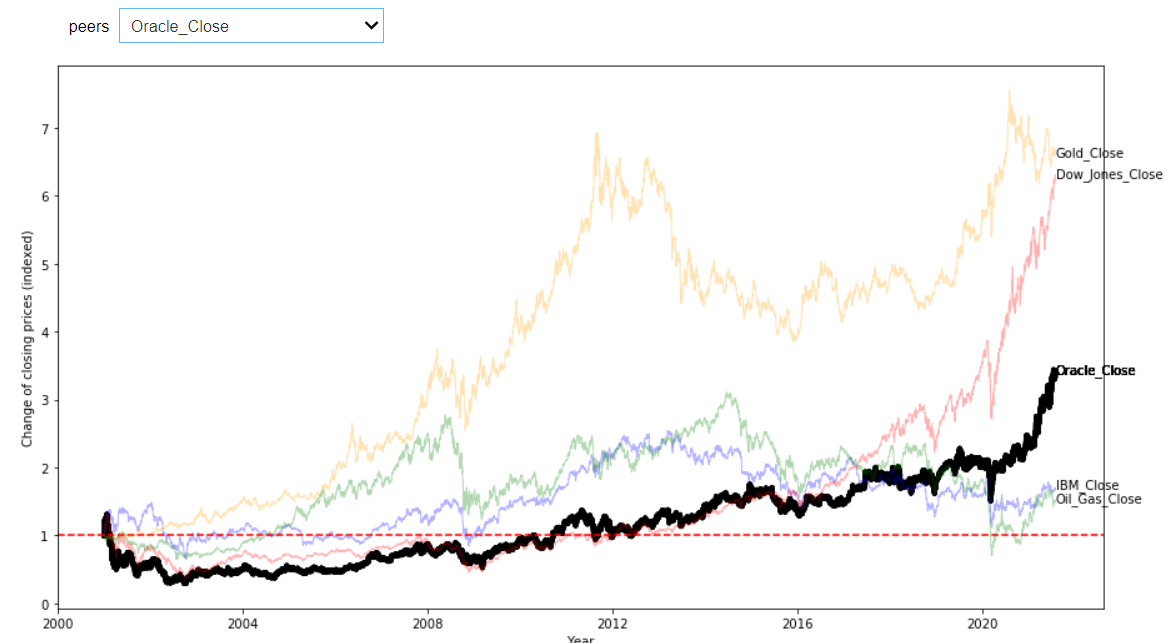

In [90]:
Image(filename='peers_chart.png')

Until 2015 sometimes the peers are valuated higher, sometimes lower than IBM. Aferwards they are all outperforming IBM (but not always Dow Jones). Maybe as an effect of the Quantitative Easing kicking off in early 2015 (see: https://www.investopedia.com/terms/q/quantitative-easing.asp). I have to pay attention to this fact because my model could learn different tendencies in the first 5 years from the peers compared to the second 5 years.

---

#### Target (output-factor)

Let's compare the distribution of IBM absolute prices vs relative prices (of previous day):

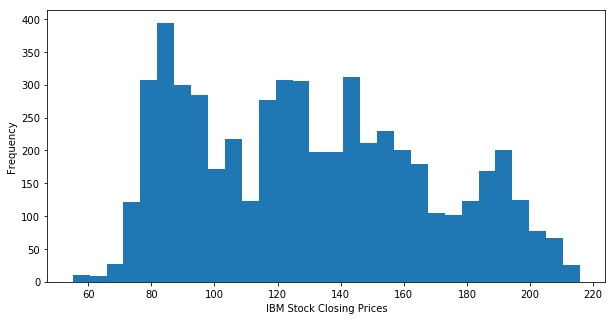

In [91]:
# Absolute prices

plt.figure(figsize=(10,5))

plt.hist(df.IBM_Close, bins=30)
plt.ylabel('Frequency')
plt.xlabel('IBM Stock Closing Prices')
plt.show();

C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


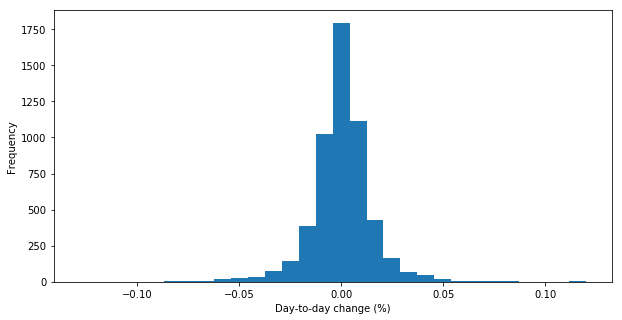

In [92]:
# Relative prices compared to previous day

plt.figure(figsize=(10,5))

plt.hist(df.IBM_Close.pct_change(1), bins=30)
plt.ylabel('Frequency')
plt.xlabel('Day-to-day change (%)')
plt.show();

Apparently the distribution is much more normal once the price is put into relation of the previous day.

Now I check whether the dataset is balanced or not, i.e. if the output values in the data set are more or less equally represented:

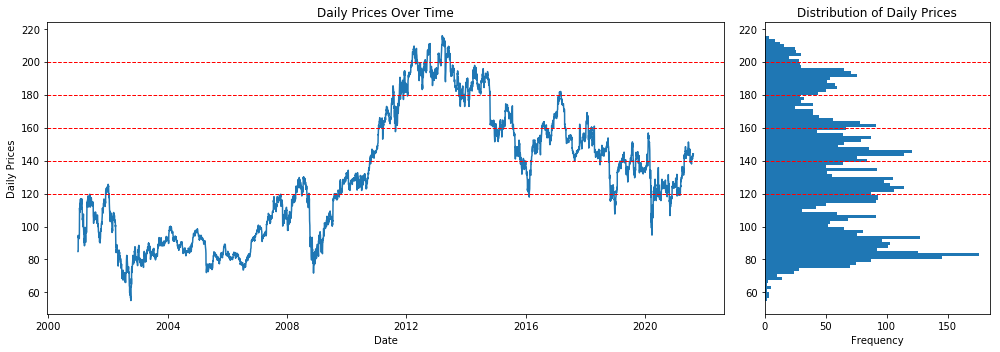

In [93]:
# Plot the trend and histogram of prices together
# initialize two subplots in 1 row and two columns. Also specify the width of each plot
fig, ax = plt.subplots(1,2,figsize=(14, 5),gridspec_kw={'width_ratios': [3, 1]})

# create the first plot for the prices over time
ax[0].set_title('Daily Prices Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Daily Prices')
ax[0].plot(df.IBM_Close.dropna(axis=0))
for i in [120,140,160,180,200]:
    ax[0].axhline(i,color='r', linewidth=1, linestyle='--')
    
# create the histogram of prices in the second plot
ax[1].set_title('Distribution of Daily Prices')
ax[1].set_xlabel('Frequency')
ax[1].hist(df.IBM_Close.dropna(axis=0),bins=90,orientation='horizontal')
for i in [120,140,160,180,200]:
    ax[1].axhline(i,color='r', linewidth=1, linestyle='--')

fig.tight_layout()
plt.show()

# copied content from the EPFL course "Applied Data Science: Machine Learning"

In [94]:
import plotly.express as px
fig=px.line(df, x=df.index, y='IBM_Close', title='IBM Stock Price with Slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# copied content from https://towardsdatascience.com/most-useful-python-functions-for-time-series-analysis-ed1a9cb3aa8b

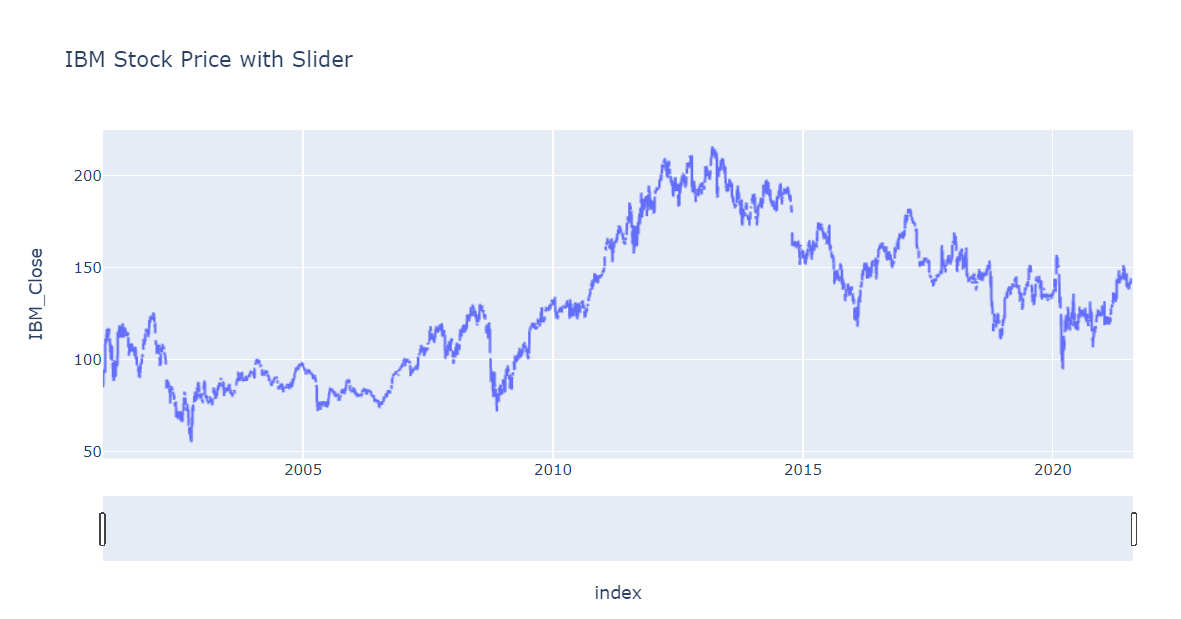

In [95]:
Image(filename='IBM_chart.png')

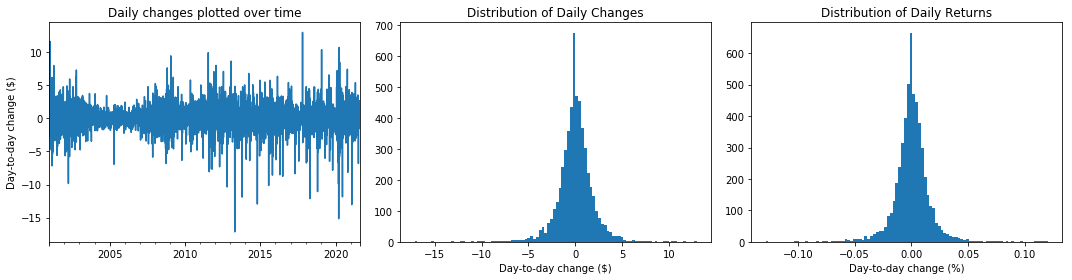

In [96]:
# Compute first difference and returns
diff = df.IBM_Close.dropna(axis=0) - df.IBM_Close.dropna(axis=0).shift(1)
returns = df.IBM_Close.pct_change(1)

# Plot the results

plt.subplot(131)
diff.plot(figsize=(15, 4))
plt.title('Daily changes plotted over time')
plt.ylabel('Day-to-day change ($)')

plt.subplot(132)
diff.hist(figsize=(15, 4),bins=100, grid=False)
plt.title('Distribution of Daily Changes')
plt.xlabel('Day-to-day change ($)')

plt.subplot(133)
returns.hist(figsize=(15, 4),bins=100, grid=False)
plt.title('Distribution of Daily Returns')
plt.xlabel('Day-to-day change (%)')

plt.tight_layout()
plt.show()

# copied content from the EPFL course "Applied Data Science: Machine Learning"

**(Preliminary) Findings of features and target:** 
- The target of my project will be the relative stock price change of IBM based on the previous day
- The date index has to be cut off at end of 2019 since the corona crisis in 2020 creates a lot of noise
- IBM seems to have substantially different valuation curve in the second half of data set compared to its peers also proven by the significantly higher Dow Jones index - I have to take a closer look at their correlations
- The single price chart of IBM indicates balanced output data since date range from 2010 to 2020 captures upwards and downwards trends (approx.) at the same scale. Same holds true for the distribution of daily prices/changes/returns. The algorithm later in the project is more likely to be biased when the data distribution is skewed which is not case for the target objective here.
- Gold price captures the re-shifting from stocks into bonds resp. gold during economic distress (e.g. aftermath of financial crisis in 2010 to 2013

---

#### Relationship between features and target 

I calculate the Pearson correlation coefficient among features since the Spearman correlation is rather used to evaluate relationships involving ordinal variables and Kendall’s rank correlation improves upon this by reflecting the strength of the dependence between the variables being compared:

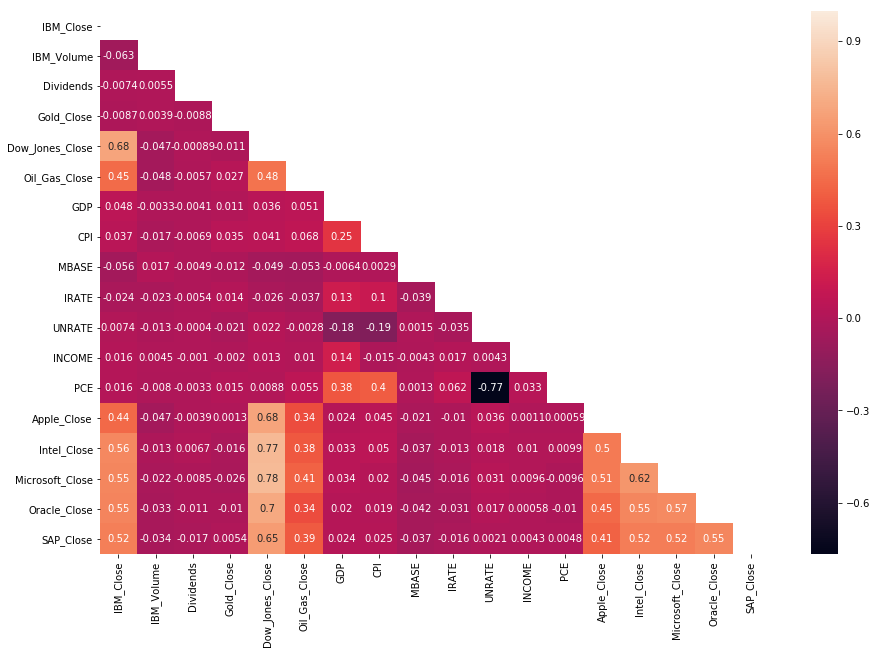

In [97]:
fig, ax = plt.subplots(figsize=(15,10))  
matrix = np.triu(df.pct_change(1).drop(['IBM_Open', 'IBM_High', 'IBM_Low'], axis=1).corr())
sns.heatmap(df.pct_change(1).drop(['IBM_Open', 'IBM_High', 'IBM_Low'], axis=1).corr(), annot=True, mask=matrix, ax=ax)

In [98]:
df.pct_change(1).corr().drop(['IBM_Open', 'IBM_High', 'IBM_Low'], axis=1).style.background_gradient(cmap="Blues")

- I ignore the IBM related feature correlation with themselves since they will be dropped after feature engineering
- On the one hand IBM has a positive correlation with its peers and Dow Jones index and oil/gas. On the other hand the correlation is almost zero 
- The peers have a stronger positive correlation with each other than with IBM as shown in the heatmap
- The FRED related features correlations close to zero, however it's difficult to interpret the relationship since the frequencies are different from IBM stock price (e.g. only 82 of income obersations might not be sufficient to determine a correlation with daily prices)

**Finding:** I note that all the features have a correlation which is not be worried about, thus I can keep all of them as input features. The peers need further investigation.

Let's review the correlation of peers with IBM in the first half of data set and compare to the second half:

In [99]:
df['2001':'2010'].pct_change(1).corr()['IBM_Close'][peers_df.columns]

Apple_Close        0.472196
Intel_Close        0.604115
Microsoft_Close    0.592697
Oracle_Close       0.561208
SAP_Close          0.544124
Name: IBM_Close, dtype: float64

In [100]:
df['2010':'2020'].pct_change(1).corr()['IBM_Close'][peers_df.columns]

Apple_Close        0.436079
Intel_Close        0.520822
Microsoft_Close    0.533115
Oracle_Close       0.560399
SAP_Close          0.520260
Name: IBM_Close, dtype: float64

The correlation has almost not changed.

The scatterplots are not really informative for the FRED related features due to low frequency. It's hard to identify clear relationships since first the data needs to be cleaned and manipulated. Therefore I am going to analyze the relation between IBM stock price and the index, gold as well as peers:

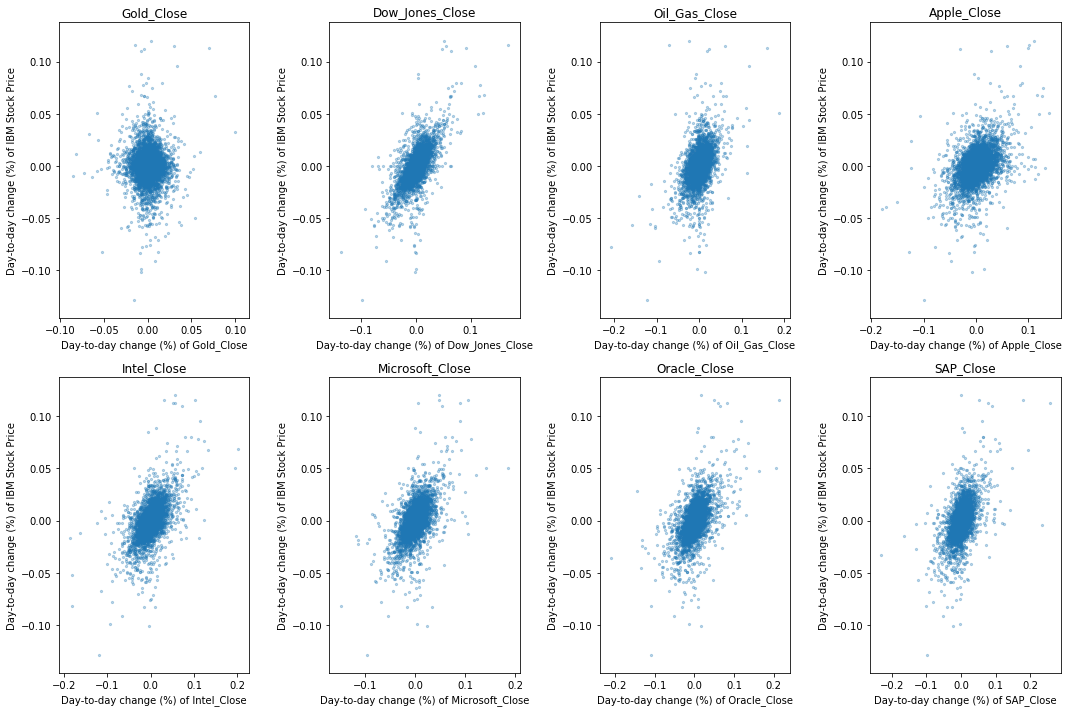

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

for column, ax in zip(close_prices.drop('IBM_Close', axis=1), axes.ravel()):
    ax.scatter(df[column].pct_change(1), df.IBM_Close.pct_change(1), alpha=0.3, s=5)
    ax.set_title(column)
    ax.set_ylabel('Day-to-day change (%) of IBM Stock Price')
    ax.set_xlabel('Day-to-day change (%) of {}'.format(column))
    
plt.tight_layout() 
plt.show()

Some features have a slightly (positive) linear relationship with IBM in terms of relative changes like Dow Jones. For Gold the stock price of IBM is going into the positive and negative direction approx. at the same level. 

> In case all features are required for scatterplot:

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 20))

for column, ax in zip(df.loc[:,'Dividends':], axes.ravel()):
    ax.scatter(df[column].pct_change(1), df.IBM_Close.pct_change(1), alpha=0.3, s=5)
    ax.set_title(column)

plt.tight_layout() 
plt.show()

---

#### Trends/seasonalities

Next I will check for particular patterns in time series perspective, i.e. over time (performance reporting (quarterly), "Sell in may, go away", Christmas time etc.):

In [102]:
# Split IBM stock price into its components with additive composition

sd = seasonal_decompose(df.IBM_Close.asfreq('B').fillna(method='bfill').fillna(method='ffill'))

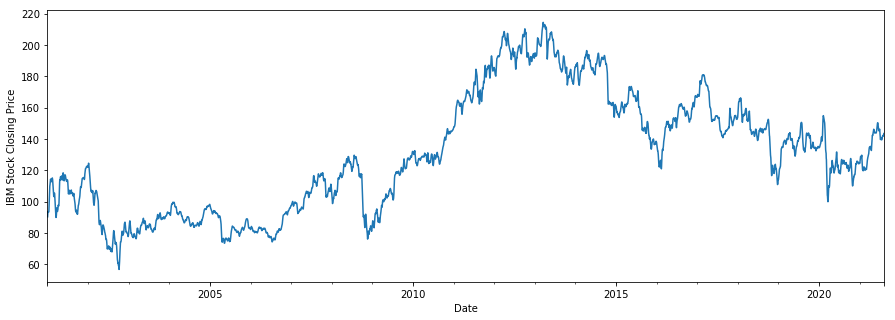

In [103]:
sd.trend.plot(figsize=(15,5))
plt.ylabel('IBM Stock Closing Price')
plt.xlabel('Date')
plt.show();

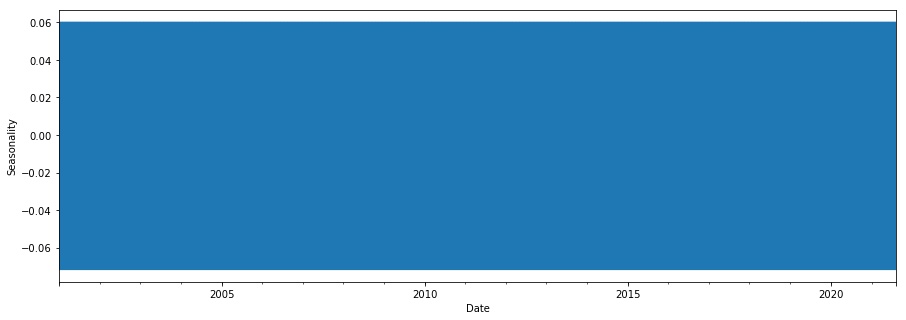

In [104]:
sd.seasonal.plot(figsize=(15,5))
plt.ylabel('Seasonality')
plt.xlabel('Date')
plt.show();

Looking at the plot we can observe there is an upward and downward trend over the period of time. The seasonal component plot does not give any clear picture therefore my conclusion is that the IBM stock price is **not seasonal**. However I will further investigate on any weekly, monthly or yearly patterns.

In [105]:
by_month = df.pct_change(1).IBM_Close.groupby(df.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_ticks = 2*np.arange(6)

# copied content from the EPFL course "Applied Data Science: Machine Learning"

In [106]:
by_quarter = df.pct_change(1).IBM_Close.groupby(df.index.quarter).mean()
by_quarter.index = ['Q1', 'Q2', 'Q3', 'Q4']
quarterly_ticks = np.arange(3)

# copied content from the EPFL course "Applied Data Science: Machine Learning"

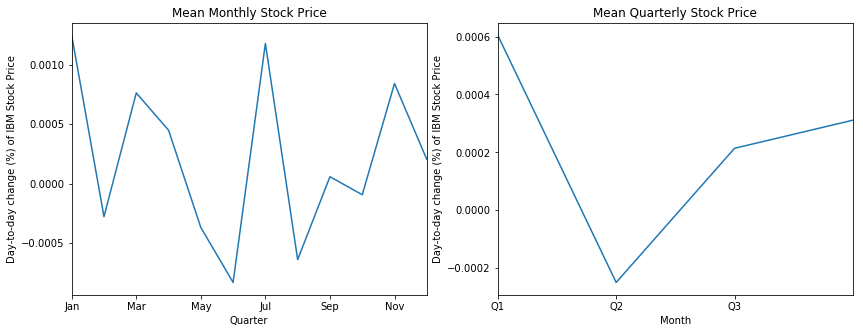

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_month.plot(ax=ax[0], title='Mean Monthly Stock Price', xticks=monthly_ticks)
by_quarter.plot(ax=ax[1], title='Mean Quarterly Stock Price', xticks=quarterly_ticks)
ax[1].set_ylabel('Day-to-day change (%) of IBM Stock Price')
ax[1].set_xlabel('Month')
ax[0].set_ylabel('Day-to-day change (%) of IBM Stock Price')
ax[0].set_xlabel('Quarter')
plt.show()

I can spot a peak in July and a clear drop around May. Reasons could be the time period of dividend payment(normally paid 10th of March) and the country lore "sell in May and go away" (= cash-in period). Both trends cause a decrease in stock prices. One could state that it's probably a good idea to buy in June and sell in July every year. The quarterly plot shows a drop in the second quarter. However even both curves indicate a clear pattern the y-axis show that the prices change in a very low scale range (0.1% to - 0.05%). 

Let's investigate on the boxplots in order to get a more objective view on the preliminary findings (e.g. median instead of mean):

In [108]:
df_new = df.pct_change(1).copy()

In [109]:
# Adding another column in df_new storing the frequency of each observation
df_new["Year"] = df_new.index.year
df_new["Quarter"] = df_new.index.quarter
df_new["Month"] = df_new.index.month

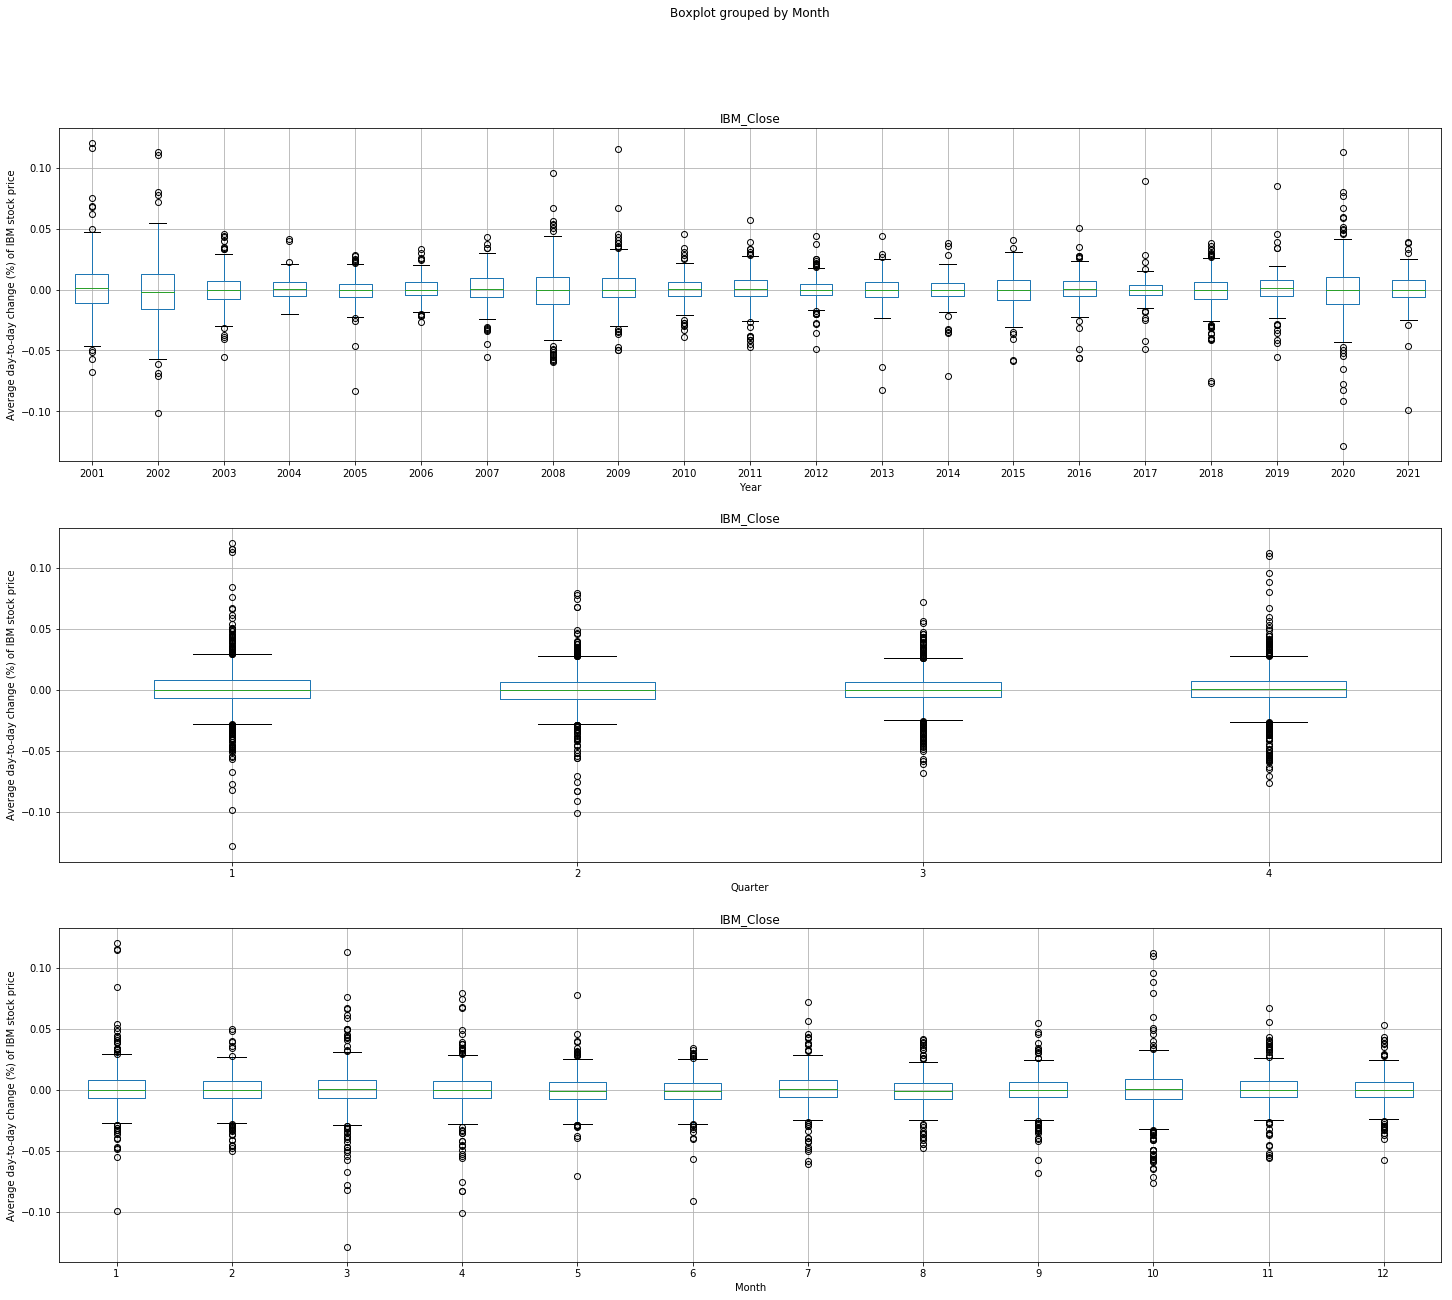

In [110]:
# Setting the size of the figure 
plt.rcParams["figure.figsize"] = 24, 21

# Defining 3 subplots
fig, axes = plt.subplots(3, 1)

# First Boxplot: Yearly IBM stock prices
df_new.boxplot(by ='Year', column =['IBM_Close'], ax = axes[0])
axes[0].set_ylabel('Average day-to-day change (%) of IBM stock price')

# Second Boxplot: Quarterly IBM stock prices
df_new.boxplot(by ='Quarter', column =['IBM_Close'], ax = axes[1])
axes[1].set_ylabel('Average day-to-day change (%) of IBM stock price')

# Third Boxplot: Monthly IBM stock prices
df_new.boxplot(by ='Month', column =['IBM_Close'], ax = axes[2])
axes[2].set_ylabel('Average day-to-day change (%) of IBM stock price')

# Displaying plots
plt.show()

**Findings:** Overall the median is always around zero and the range from 25%-75% do not change substantially over months/quarters/years. Therefore I will not account for any trend in my data set. In addition I have already accounted for the dividend aspect in my data set in order to address the small drop in Q2. I spot some deviation in 2002, 2008 and 2020 as a result of the crisis (dot-com, financial crisis, corona). I could highlight the economic crisis in my data set but I'm not sure if the algorithm will be rather confused than feeded with helpful information since the boxplots do not heavily differ. Plus the effect of corona can be neglected since my data set will be cut off at the end of 2019. This is why I do not encode these economic downturns. The outliers will be removed later in the project.

---

Check for weekdays trends:

In [111]:
by_day = df.IBM_Close.pct_change(1).groupby(df.index.weekday).mean()

In [112]:
by_day = by_day[0:5]

In [113]:
by_day.index = ['Mo', 'Tu', 'We', 'Th', 'Fr']

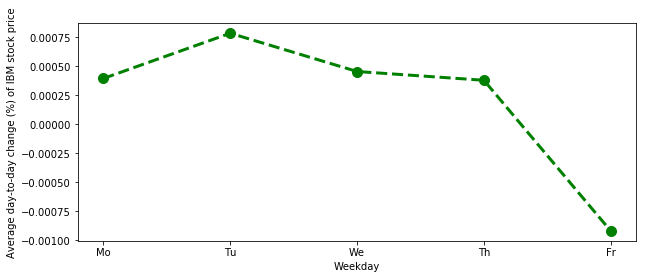

In [114]:
plt.figure(figsize=(10,4))
plt.plot(by_day,marker='o', linestyle='--', linewidth=3,markersize=10, color='g')
plt.ylabel('Average day-to-day change (%) of IBM stock price')
plt.xlabel('Weekday');

There seems to be clear selling trend on Fridays although the percentage change is not very high.

In [115]:
by_day = df.pct_change(1).IBM_Volume.groupby(df.index.dayofweek).mean()
by_day = by_day[0:5]
by_day.index = ['Mo', 'Tu', 'We', 'Th', 'Fr']

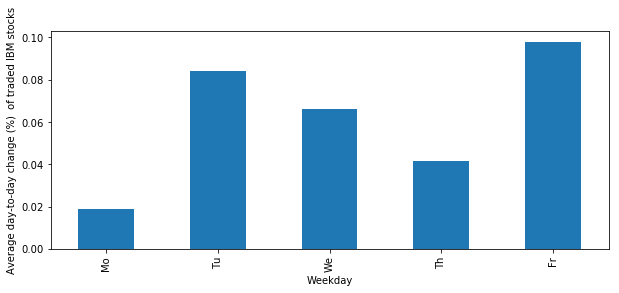

In [116]:
plt.figure(figsize=(10,4))
by_day.plot(kind='bar')
plt.ylabel('Average day-to-day change (%)  of traded IBM stocks')
plt.xlabel('Weekday');

The trading activities differ significantly during weekdays. Especially on Mondays the stock is traded five times less than on Fridays.  

**Findings:** Overall I have to account for the Mondays and Fridays in the data set. No highlight of other trends required.

---

#### Stationarity/non-stationarity

Let's see if the distribution of data is changing over time. Content copied from here: https://analyzingalpha.com/check-time-series-stationarity-python

In [117]:
X = df.IBM_Close
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=100.901633, mean2=159.749353
variance1=435.287915, variance2=668.242008


The mean/variance analysis of the first ten years compared to the second ten years indicate non-stationarity. Let's proof it with a statistical test designed for this situation.

Augmented Dickey–Fuller test:

> The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series $y_{t-1}$ will provide no relevant information in predicting the change in $y_{t}$. In this case the $\gamma = 0$ and null hypothesis is not rejected. In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

In [118]:
t_stat, p_value, _, _, critical_values, _  = adfuller(df.IBM_Close.dropna().values, autolag='AIC')

In [119]:
print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

ADF Statistic: -1.53
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57


**Findings:** You can compare the ADF test statistic of -1.51 against the critical values. I see that the test statistic is less than all of the critical values hence I cannot reject the null hypothesis – in other words, IBM’s stock price is **non-stationary**; its mean and variance are changing. 

>After transforming the time series with pct_change(1) it's statistical properties (mean, variance) and the ADF test indicate that the time series is stationary:

In [120]:
X = df.IBM_Close.pct_change(1)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.000384, mean2=0.000052
variance1=0.000275, variance2=0.000203


In [121]:
t_stat, p_value, _, _, critical_values, _  = adfuller(df.IBM_Close.pct_change(1).dropna().values, autolag='AIC')

In [122]:
print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

ADF Statistic: -19.20
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57


---

#### Autocorrelations or temporal dependencies

Next I will visually inspect and statistically analyze if the price today is dependent with the price of yesterday for the following columns:

In [123]:
list(close_prices.columns)

['IBM_Close',
 'Gold_Close',
 'Dow_Jones_Close',
 'Oil_Gas_Close',
 'Apple_Close',
 'Intel_Close',
 'Microsoft_Close',
 'Oracle_Close',
 'SAP_Close']

In [124]:
# Content copied from here: https://analyzingalpha.com/check-time-series-stationarity-python

The autocorrelation and partial-autocorrelation functions analyze a data set for statistical significance between the first data point and prior data points.

A **non-stationary** time series data will show significance between itself and its lagged values, and that significance will decay to zero slowly as in the first plot:

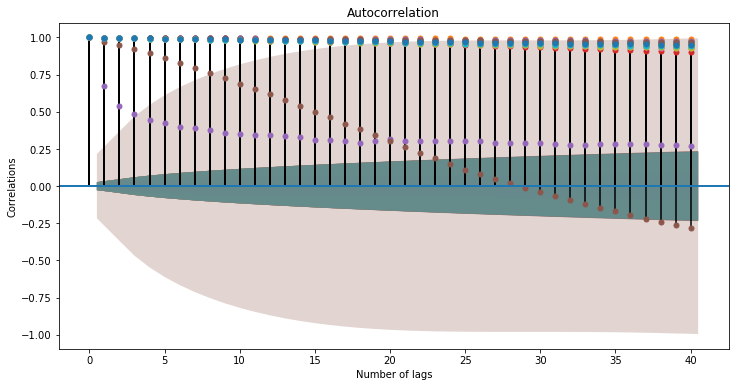

In [125]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))

for x in df.columns:
    plot_acf(df[x].dropna(), lags=40, alpha=0.05,ax=ax)

    plt.ylabel('Correlations')
plt.xlabel('Number of lags')
plt.show();

Note: if the autocorrelation value lies within the shadow area the values is not significant. If it lies outside, it is significant.

Indeed the time series data have autocorrelation for lag = 1 for all features, meaning if the price changes from today to tomorrow 2% the price will usually not change significantly more or less the day after (e.g. 10%). The autocorrelation persists with 5-day lag, 10-days lag etc. Another method to make this observation visually effective is the lag_plot tool below. Each graph shows  𝑦𝑡  plotted against  𝑦𝑡−𝑙𝑎𝑔 , where lag ranges from 1 to 12 and 𝑦 = IBM stock price.

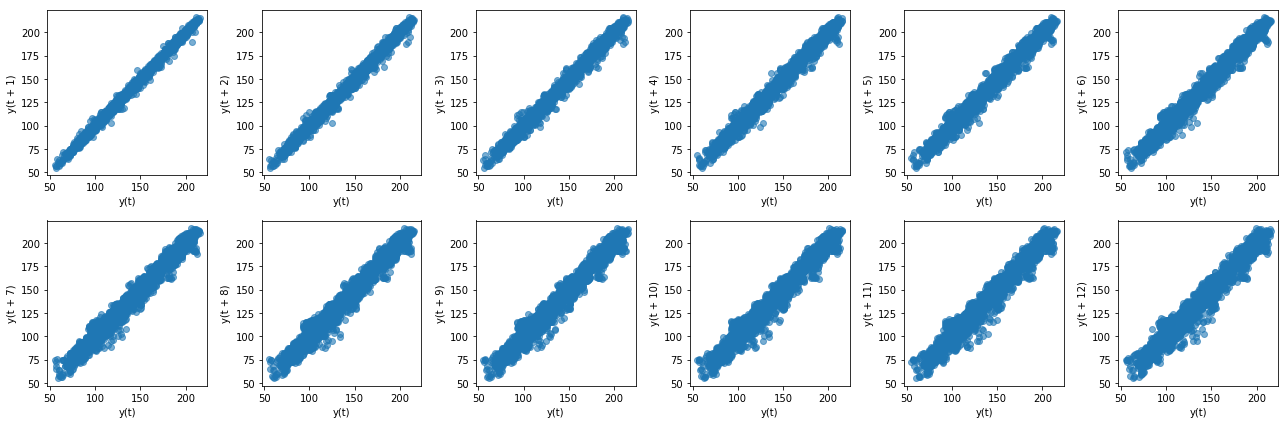

In [126]:
# Lag plot of IBM stock price

fig,axes = plt.subplots(2,6,figsize=(18,6))

for lag,ax in zip(np.arange(1,13),axes.ravel()):
    pd.plotting.lag_plot(df.IBM_Close, lag=lag,ax=ax,alpha=0.6)

plt.tight_layout();

The second plot, a **stationary** time series (limited to IBM stock price) due to the pct_change(1) function, will quickly drop to zero with lag =1. The brown shadow are confidence intervals where values above or below the lines are more significant than two standard deviations.

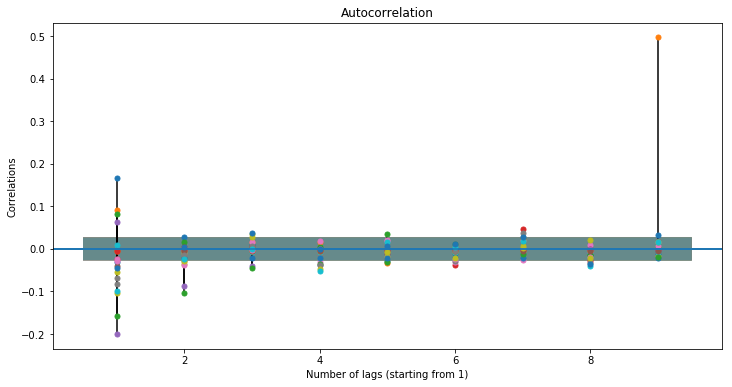

In [127]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))

for x in df.columns:
    plot_acf(df[x].pct_change(1).dropna(), lags=np.arange(1,10), alpha=0.05,ax=ax)

    plt.ylabel('Correlations')
plt.xlabel('Number of lags (starting from 1)')
plt.show();

**Findings:** The autocorrelation function plot suggests that correlation still exists at certain lags after transforming the features (e.g. for lag = 1 the values are not within the confidence interval). However I have already proven above that the transformation with pct_change(1) will make the time series stationary. The analysis was key since I want to build a regression model. One of the assumptions of regression analysis is that the data has no autocorrelation, otherwise the analysis will be misleading. Therefore the transformation of time series is mandatory.

## 4) Machine learning 

### (a) Phrase your project goal as a clear machine learning question

My machine learning question is the following:

> Will my trained model outperform the naive baseline model due to the additional feature extension and comprehensive feature engineering based the pre-defined evaluation metrics?

- Features: 
    - change of peers' stock price in percentage of the previous day
    - change of IBM's stock price in percentage of the previous day
    - change of index, gold, oil/gas price in percentage of the previous day
    - change of FRED data in percentage of the previous day
- Target: change of IBM stock price in percentage
- My question is a regression problem since I want to predict a quantitative, continuous-valued attribute associated with an object 

### (b) What models are you planning to use and why?

In my project, the input (features) and output (IBM stock price) are clearly identified, so I can say we have labeled input and output data; therefore, we’re dealing with **supervised** learning. Two common types of supervised learning algorithms are Regression and Classification.

- Regression: They’re used to predict continuous values such as price, salary, age, etc
- Classification: They’re used to predict discrete values such as male/female, spam/not spam, positive/negative, etc.


It’s now evident that I should use **regression** algorithms since I'm going to predict continuous values (stock price) instead of a classified values (e.g. buy/sell). I can use machine learning models categorized as supervised from the EPFL courses and will select & rank them according to the following criteria: 
> performance of the model ¦ explainability of results ¦ model's complexity ¦ size of data set ¦ dimensionality of the data

**Linear regression (LR):** LR are usually applied when the output is continuous. It's a simple technique and easy to interpret, but there are disadvantages. For stock market analysis, the data is non-linear hence maybe less suitable and there exists dependencies between the features (e.g. peers stock prices). LR can overfit too – this typically happens when there are more features than the number of instances in the training data. For time series the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.
    
>Scikit-learn provides a **LR estimator** to compute the OLS solution which uses the lstsq() function internally. It's very convenient to work with this object since it implements the estimator API. 

>It's also possible to fit linear regressions with the **Ridge-Regressor estimator** from Scikit-learn which is similar to the LR. I will use it to tackle ill-conditioning (nearly collinear features like the peers stock prices) in order make computations numerically stable which result in lower variations in the model coefficients. Note: modifying the objective function and adding a regularization term that penalizes large coefficients does not necessarily affect the predictive accuracy of the model.

**K-Nearest Neighbors (kNN):** kNN could identify certain "drop patterns" in the data as well (e.g. January 2018) and thus will probably not performed well on this dataset. Plus a KNN model is much better with fewer examples which is not the case in this project. Imbalanced data like in this project causes problems but using weighted distances can overcome this. Therefore I will try to implement this model.
> K-Nearest Neighbors Regression → The output would determine property value for the object. Therefore, the new instance would be classified as the average of the values of the k Nearest Neighbors

**Random Forest (RF):** RF are an ensemble learning technique that builds off of decision trees (I don't apply simple decision trees because it's tending to overfitting due to its structure). Decision trees are intuitive and easy to build. However the newly created features are provided for the training of each decision tree which in turn determines the decision at the nodes of the tree. Unfortunately the tree could grow in a completely different direction as compared to the expected growth due to the usually high level of noise in stock market data. In addition the model is more prone to overfitting. Nevertheless I will try to implement this model too since the next one is considered as deep learning.

**Artificial Neural Network (ANN):** Stock prices are dependent on multiple parameters which form complex patterns. ANN should be suitable for finding hidden features through a self learning process and automatically extracting features based on quantitative data and the model explainability is rather low. An ANN can in theory approximate any continuous real function thus highly suitable for stock prices. However a neural network is really good at processing and synthesizing tons of data (incl. high dimensions) which is not the case in this project but is prone to overfitting.

Ranking of my approaches (incl. criteria):
1. LR/Ridge Regression (high explainability, low complexity)
2. kNN (data set is not small)
3. RF (high complexity)
4. ANN (low explainability, high complexity)

If I end up with a long list of features I can do PCA and feed model with reduced data (high dimensionality)

*Principal Component Analysis (PCA):* PCA would be a good method (**not a model**) for datasets with a large number of features if the dimensionality affects the complexity of a model. A high-dimensional dataset is not the case in this project. However it would be nice to add as a preprocessor because it serves to remove highly correlated features (like IBM peers stock prices) and redundant ones and trims away noise in the data.

### (c) Please tell us your detailed machine learning strategy 

- Sample split strategy (2020 not included due to corona)
    - Training data: Jan 2001- Dec 2019
    - Test data: Q1 & Q2 2021
- First of all the baseline model will be created with only one feature 
- Afterwards the ML models from b) will be trained with **additional** data not related to IBM (feature extension) and feature engineering
- Before/after comparison of the ML models with the baseline model to be executed in order to infer higher/lower performance

**Typical Machine Learning Lifecycle**:
- Pre-Processing 
    - Clean the data such that the algorithm can run with minimal distortion (e.g. filling missing values, removing outliers) 
    - Standardization: involves adjusting values measured on different scales to a common scale. MinMaxScaler converts the values to be strictly between 0 and 1 (applied when the feature is not distored), StandardScaler transforms dataset into mean = 0 (apply when the feature conforms to normal distribution) whereas RobustScaler transforms dataset into median = 0 (applied when the feature has skewed distributions and outliers)
- Feature Selection: simple and complex model based on which feature contribute most to the model
- Feature Engineering (see above) 
- Model Selection (see above) 
- Cross Validation (CV): traditional CV is NOT appropriate since the training set of time series data should not be divided into multiple folds using a different subset each time for training the model to learn the parameters of a prediction model. Randomly picking samples out of the available data and split it in train and test set is a problem because time series data needs to be in a chronological order. There is a temporal dependency between observations, and we must preserve that relation during testing. Instead I will use a special CV with time blocks called 'TimeSeriesSplit'. The idea is to use a rolling base method for CV. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted. See below a visual representation of the CV where 'data' refers to the sum of training data in the sample split strategy. 
- Evaluation Metrics (see above) 
- Testing: training data set for training the model including hyperparameter tuning and testing will be executed to test independently the model with the test data set

https://scikit-learn.org/stable/


*CV for time series ('Data' input refers to the Training data in the sample split strategy):*

In [128]:
# Copied content from here: 

# - https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme 
# - https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
Image(filename='timeseriessplit.png')

**Hyperparameter Tuning:**

I try to improve the performance by searching for best parameters for my models. While selecting a range of values for each parameter to be tested, I fit with the training set and then I retrieve the best estimator based on the validation set. The GridSearch mechanism will be exloited over the following set of hyperparameters:

- LR: L1/L2 which addresses for overfitting
> - L1 regularization, also known as Lasso (in regression problems), combats overfitting by shrinking the parameters towards 0. This makes some features obsolete (it’s a form of feature selection). If the input features of my model have weights closer to 0, our L1 norm would be sparse. Something to consider when using L1 regularization is that when we have highly correlated features, the L1 norm would select only 1 of the features from the group of correlated features in an arbitrary nature, which is something that we might not want.
> - L2 regularization, or Ridge (in regression problems), combats overfitting by forcing weights to be small, but not making them exactly 0. A major downside to consider when using L2 regularization is that it’s not robust to outliers. Since I remove the outliers during the cleaning process this will not be considered as an issue. 
> - source: https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization

- kNN: the positive integers of k and how i measure distance between data points
> - By default, Euclidian distance is used, which works well in many settings. However, as the k value changes, the measure method can be adjusted by the user and different results can be obtained. 
- RF: n_estimators and max_depth
- Artificial Neural Network: no finetuning required according to the instructions


**Baseline model:**  I simply use the percentage change in IBM's closing price of the previous day for predicting the target. For example if the price changed from $y_{t-2}$ to $y_{t-1}$ approx. 2% then the predicted change of the baseline model from $y_{t-1}$ to $y_{t}$ will be 2% as well.

**Metrics and evaluation methodologies**: 

MSE, MAE and R² (coefficient of determination) => these metrics are key criterions for assessing the quality/performance of a regression model

MSE = Variance + Bias
- This is the essence of the bias-variance-trade-off: if the complexity is too low or too high we will have a high Mean Squared Error respectively due to Bias or Variance. The point is how to get model flexibility just right, in order to minimize both Bias and Variance at the same time. This is where hyperparameter tuning will be applied.
- The ML model can be backtested using available historical to see if it's a viable prediction

R² can be understood as a standardized version of the MSE. This allows an easier interpretation of the performance of the model. 

## 5) Implementation of the idea

#### Outlier removal

For time series we often look for points which deviate from local behavior (local outliers). Below we detect local outliers by using the rolling window (bollinger bands) to compare a value with its preceding values (center=False). Here we use the rolling mean and rolling standard deviation to create bounds on acceptable values. A value that falls outside these bounds is flagged as an outlier candidate (red dot in the plot below):

In [129]:
def detect_outliers_rolling(timeseries, days=10, n_std=2, center=False):

    rolling_mean = timeseries.rolling(window=days, center=center).mean()
    rolling_std = timeseries.rolling(window=days, center=center).std()
    lower_bound = rolling_mean - (n_std * rolling_std)
    upper_bound = rolling_mean + (n_std * rolling_std)

    # Identify outliers
    mask = (timeseries < lower_bound) | (timeseries > upper_bound)
    mask.sum()
    outliers = timeseries[mask]


    # Plot bounds and outliers
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, "lightblue", label="IBM Closing Price")
    plt.plot(rolling_mean, "orange", label="Rolling mean of IBM Closing Price")
    plt.plot(upper_bound, "r--", label="Bounds", alpha=0.5)
    plt.plot(lower_bound, "r--", label="", alpha=0.5)
    plt.plot(outliers, "ro", markersize=5, label="Outlier candidate of IBM Closing Price")
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(
        "{} outliers detected using a moving window of size = {}".format(
            len(outliers), days
        )
    )
    
    plt.ylabel('Price Value')
    plt.xlabel('Date')
    plt.show()

# Copied content from EPFL course

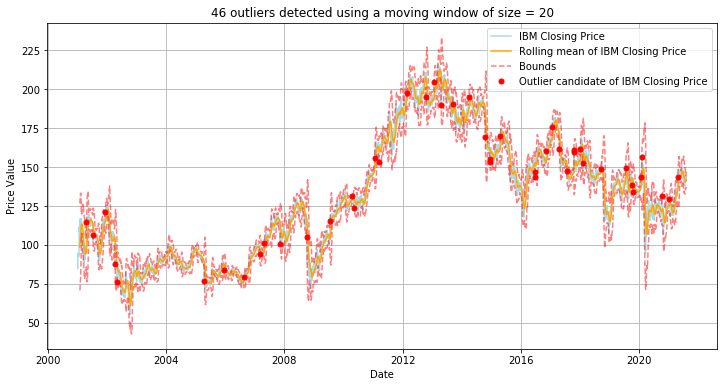

In [130]:
detect_outliers_rolling(df.IBM_Close, days=20, n_std=3, center=False)

Let's remove outliers for all features with **closing prices**:

In [131]:
for column in close_prices.columns:
    
    rolling_mean = df[column].rolling(window=20, center=False).mean()
    rolling_std = df[column].rolling(window=20, center=False).std()
    lower_bound = rolling_mean - (3 * rolling_std)
    upper_bound = rolling_mean + (3 * rolling_std)
    
    mask_low = df[column][df[column] < lower_bound]
    mask_up = df[column][df[column] > upper_bound]
    
    for i in mask_low.index:
        df[column][i] = lower_bound[i]
    
    for i in mask_up.index:
        df[column][i] = upper_bound[i]

For **FRED** related features we can apply the IQR or z-score based on their distributions:

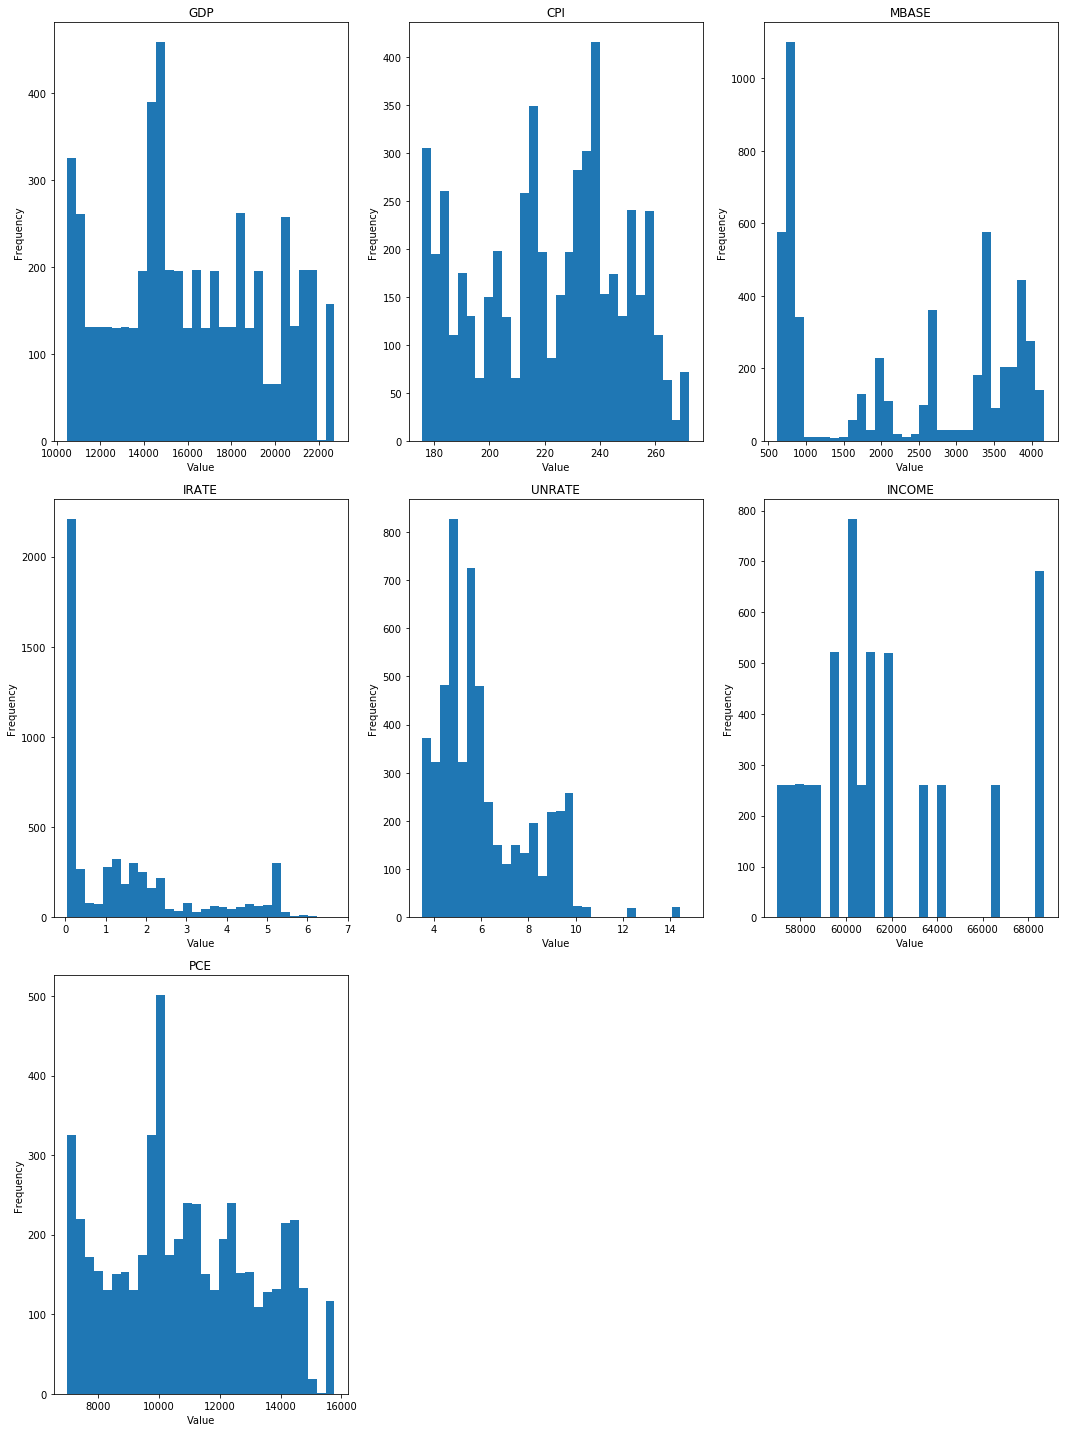

In [132]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))

for c, ax in zip(df[FRED_df.columns], axes.ravel()):
    ax.hist(df[c], bins=30)
    ax.set_title(c)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()

plt.tight_layout() 
plt.show()

INCOME, IRATE, MBASE and UNRATE seem to be skewed - consequences: on the one hand we have to apply log-transformations before the outliers will be spotted, on the other hand the outliers have to be removed based on IQR calculation. Insead of removal I will replace outliers with max value (lower bound respectively upper bound):

In [133]:
# apply log-transformation upfront for the skewed features
Q1 = np.nanpercentile(np.log1p(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']]), 25, axis=0)
Q3 = np.nanpercentile(np.log1p(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']]), 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [134]:
boxplot_filter = (df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']] < np.exp(lower_bound)-1) | (df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']] > np.exp(upper_bound)-1)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

Number of outliers detected per feature using a boxplot:
INCOME     0
IRATE      0
MBASE      0
UNRATE    22
dtype: int64
Total number of outliers detected: 22


In [135]:
np.exp(upper_bound)-1

array([6.95513148e+04, 1.34292308e+01, 3.00973889e+04, 1.38048464e+01])

In [136]:
np.exp(lower_bound)-1

array([ 5.41718641e+04, -7.54879518e-01,  9.59200134e+01,  2.21482566e+00])

In [137]:
for i in enumerate(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']], start=0):
    print(i[0], i[1])

0 INCOME
1 IRATE
2 MBASE
3 UNRATE


In [138]:
for i in enumerate(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']], start=0):
    df[i[1]] = np.where((df[i[1]] < (np.exp(lower_bound)-1)[i[0]]),(np.exp(lower_bound)-1)[i[0]],df[i[1]])

In [139]:
for i in enumerate(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']], start=0):
    df[i[1]] = np.where((df[i[1]] > (np.exp(upper_bound)-1)[i[0]]),(np.exp(upper_bound)-1)[i[0]],df[i[1]])

CPI, GDP and PCE have a rather normal distribution - apply z-score for outlier removal since their distributions are not skewed:

In [140]:
zscores_df = (df.loc[:,['CPI', 'GDP', 'PCE']] - df.loc[:,['CPI', 'GDP', 'PCE']].mean()) / (df.loc[:,['CPI', 'GDP', 'PCE']].std())
zfilter_df = np.abs(zscores_df) > 3

In [141]:
print("Number of outliers detected per feature using z-scores:")
print(zfilter_df.sum(axis=0))
print("Total number of outliers detected:", zfilter_df.sum(axis=0).sum())

Number of outliers detected per feature using z-scores:
CPI    0
GDP    0
PCE    0
dtype: int64
Total number of outliers detected: 0


No outliers to be removed.

---

Feature selection:

In [142]:
for x in df.columns:
    print(x, df[x].value_counts().sort_values(ascending=False).head(1)/df.shape[0])

IBM_Open 92.0    0.001674
Name: IBM_Open, dtype: float64
IBM_High 100.0    0.001302
Name: IBM_High, dtype: float64
IBM_Low 92.550003    0.001116
Name: IBM_Low, dtype: float64
IBM_Close 82.5    0.001302
Name: IBM_Close, dtype: float64
IBM_Volume 15132800.0    0.00093
Name: IBM_Volume, dtype: float64
Dividends 0.3    0.000744
Name: Dividends, dtype: float64
Gold_Close 1194.0    0.001302
Name: Gold_Close, dtype: float64
Dow_Jones_Close 460.75    0.001116
Name: Dow_Jones_Close, dtype: float64
Oil_Gas_Close 235.75    0.00093
Name: Oil_Gas_Close, dtype: float64
GDP 22722.581    0.017482
Name: GDP, dtype: float64
CPI 177.55    0.011717
Name: CPI, dtype: float64
MBASE 3382.8    0.07997
Name: MBASE, dtype: float64
IRATE 0.09    0.073089
Name: IRATE, dtype: float64
UNRATE 4.95    0.031616
Name: UNRATE, dtype: float64
INCOME 68703.0    0.126651
Name: INCOME, dtype: float64
PCE 15771.6    0.009485
Name: PCE, dtype: float64
Apple_Close 0.303393    0.001116
Name: Apple_Close, dtype: float64
Intel_Cl

For example 12% of INCOME values are the same. This might imply a low variance and therefore not adding a lot of value to the modelling power. However the reason for this amount could be that I have filled the missing values with bfill and ffill methods. Overall the variance can still be significant for INCOME.

A common feature selection approach that I like to use is to simply discard features that have low variance as they provide minimal signal (if I think of it in terms of signals and noises).

In [143]:
def remove_low_variance(input_data, threshold = 0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

# Code copied from here: https://towardsdatascience.com/how-to-master-scikit-learn-for-data-science-c29214ec25b0

In [144]:
# Disregard the target

df_highv = remove_low_variance(df.drop('IBM_Close', axis=1), threshold=0.1)

In [145]:
df_highv.columns.difference(df.drop('IBM_Close', axis=1).columns)

Index([], dtype='object')

I keep all features since no one has been dropped based on the VarianceThreshold function. Note: some regularization of models like L1 can be considered as "feature selection" since they put certain feature coefficients almost to zero.

Note: IBM_Open, IBM_High and IBM_Low will be dropped later since I need them for feature engineering first.

---

Feature Engineering:

Since the Dividend variable only a low amount of non-null values it doesn't add "modeling power" to the model if I keep the original feature. Therefore it's useful to encode the entire column with 0/1 indicator variable. 

In [146]:
def transform_1(x):
    if pd.isna(x) == True:
        return 0
    else:
        return 1
    return x

In [147]:
df.Dividends = df.Dividends.apply(transform_1)

In [148]:
df.Dividends = df.Dividends.astype('float64')

Continue working on a copy of the orginial data frame:

In [149]:
df_eng = df.copy()

In [150]:
# Add previous change of day price of IBM for baseline model only

df_eng['IBM_Close_t-1'] = df_eng.IBM_Close.shift(1)

In [151]:
df_eng['H-L'] = df_eng['IBM_High'] - df_eng['IBM_Low']

In [152]:
df_eng['O-C'] = df_eng['IBM_Open'] - df_eng['IBM_Close']

In [153]:
df_eng['IBM 7 Days Mean'] = df_eng['IBM_Close'].rolling(window=7).mean()

In [154]:
df_eng['IBM 14 Days Mean'] = df_eng['IBM_Close'].rolling(window=14).mean()

In [155]:
df_eng['IBM 21 Days Mean'] = df_eng['IBM_Close'].rolling(window=21).mean()

In [156]:
df_eng['IBM 7 Days Std'] = df_eng['IBM_Close'].rolling(window=7).std()

In [157]:
df_eng['IBM 52 Days High'] = df_eng['IBM_Close'].rolling(window=52).max()

In [158]:
df_eng['IBM 52 Days Low'] = df_eng['IBM_Close'].rolling(window=52).min()

In [159]:
df_eng['Friday'] = (df_eng.index.day_name() == 'Friday').astype(float)

In [160]:
df_eng['Monday'] = (df_eng.index.day_name() == 'Monday').astype(float)

In [161]:
df_eng['Sharpe Ratio'] = df_eng['IBM_Close'].pct_change(1).rolling(window=7).mean()/df_eng['IBM_Close'].pct_change(1).rolling(window=7).std()

I have to index the dataframe with respect to non-null values since feature engineering steps like rolling mean created new nan values:

In [162]:
df_eng.notna().idxmax().max()

Timestamp('2001-03-13 00:00:00')

In [163]:
df_eng = df_eng.loc[df_eng.notna().idxmax().max():]

In [164]:
# Apply log-transformation where required

df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']] = np.log1p(df.loc[:,['INCOME', 'IRATE', 'MBASE', 'UNRATE']])

Transform data into pct_change(1) to turn the data series into stationarity. I have to leave out the features which are already stationary ('Dividends','Friday', 'Monday'). Before this step I have to check if there are any null values since the transformation will result in 'inf' values:

In [165]:
df_eng[df_eng == 0].count()

IBM_Open               0
IBM_High               0
IBM_Low                0
IBM_Close              0
IBM_Volume             0
Dividends           5245
Gold_Close             0
Dow_Jones_Close        0
Oil_Gas_Close          0
GDP                    0
CPI                    0
MBASE                  0
IRATE                  0
UNRATE                 0
INCOME                 0
PCE                    0
Apple_Close            0
Intel_Close            0
Microsoft_Close        0
Oracle_Close           0
SAP_Close              0
IBM_Close_t-1          0
H-L                    0
O-C                   28
IBM 7 Days Mean        0
IBM 14 Days Mean       0
IBM 21 Days Mean       0
IBM 7 Days Std         0
IBM 52 Days High       0
IBM 52 Days Low        0
Friday              4261
Monday              4261
Sharpe Ratio           0
dtype: int64

In [166]:
df_eng['O-C'].replace(to_replace=0, method='ffill', inplace=True)

In [167]:
df_eng.loc[:, ~df_eng.columns.isin(['Dividends','Friday', 'Monday'])] = df_eng.loc[:, ~df_eng.columns.isin(['Dividends','Friday', 'Monday'])].pct_change(1)

In [168]:
# First row changed to NA values due to .pct_change(1) transformation

df_eng.drop(df_eng.index[0], inplace=True)

In [169]:
df_eng.isna().sum().sum()

0

In [170]:
df_eng.columns.shape

(33,)

Since the number of features is overseeable I will not apply PCA which is one way to address dimensionality reduction (unless my computer resources is not sufficient).

---

Sample and time series split:

I need to make sure that the test sets cover a later period in time from the training set, to prevent any information about the future from "leaking" into the model during training. Therefore I have to split the training/test set manually since time series are not suitable for random 'train_test_split' module from scikit.

In [171]:
# corona crisis dropped

df_train = df_eng['2001':'2019']

In [172]:
# only Q1 and Q2

df_test = df_eng['2021'][df_eng['2021'].index.quarter != 3]

In [173]:
# only used for the baseline model

df_test_baseline = df_eng['2021'][df_eng['2021'].index.quarter != 3]

Pick the appropriate columns for the models:
- IBM_Open is represented with the previous day closing price feature
- IBM_High/ IBM_Low are represented with feature engineering variables
- IBM_Close_t-1 is no longer useful for the models (except baseline) since I have made the time series data stationary

Afterwards transform into values because scikit algorithms only work with arrays:

In [174]:
X_tr = df_train.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).values

In [175]:
X_te = df_test.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).values

In [176]:
y_tr = df_train.IBM_Close.values

In [177]:
y_te = df_test.IBM_Close.values

In [178]:
print('Train set')
print('---------')
print('Features: {} Target: {}\n'.format(X_tr.shape,y_tr.shape))
print('') 
print('Test set')
print('--------')    
print('Features: {} Target: {}'.format(X_te.shape,y_te.shape))

Train set
---------
Features: (4905, 29) Target: (4905,)


Test set
--------
Features: (129, 29) Target: (129,)


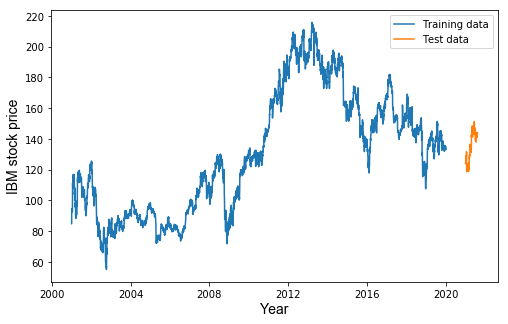

In [179]:
plt.figure(figsize=(8,5))

plt.plot(df['2001':'2019'].IBM_Close,label='Training data')
plt.plot(df['2021':].IBM_Close,label='Test data')

font_dict = {'fontname':'Arial', 'size':'14'}

plt.xlabel('Year',fontdict=font_dict)
plt.ylabel('IBM stock price',fontdict=font_dict)
plt.legend()
plt.show()

Standardization:

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization (e.g. regularization is sensitive to the scale of our features or k-NN is sensitive because it uses a distance metric). Another reason why feature scaling is applied is that gradient  descent converges much faster with feature scaling than without it

In [180]:
# Feature standardization makes the values of each  feature in the data have zero-mean 

scaler = StandardScaler()

In [181]:
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

It's often a good idea to average the scores on different train/test splits to get more stable results. This is called cross-validation. I will use TimeSeriesSplit later on in the project for training my models:

In [182]:
# time split due to time series data with four splits

time_split = TimeSeriesSplit(n_splits=4)

# shapes of training and test sets when inserting the training set

[(el[0].shape, el[1].shape) for el in time_split.split(X_tr_rescaled)]

[((981,), (981,)), ((1962,), (981,)), ((2943,), (981,)), ((3924,), (981,))]

In [183]:
# Copied content from here: 

# - https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme 
# - https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

In [184]:
# save the features in order to map them to the respective coefficients after my models have been trained

features = df_train.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).columns

---

##### Baseline Model

In [185]:
# I simply use the pct_change(1) of previous day in order to predict the target

y_pred = df_test_baseline['IBM_Close_t-1'].values

Intuitively, $R^2$ measures how well a model performs compared to the constant mean baseline. Unlike cost functions, the coefficient $R^2$ does not directly express the error made by our model. In fact, we can interpret it as a comparison between our model and the constant mean baseline. This is why it cannot be used for the baseline model. However the MAE score can be applied in order to compare the subsequent models:

In [186]:
MSE(y_te, y_pred)

0.0005136763436064487

In [187]:
MAE(y_te, y_pred)

0.016271966453949682

In [188]:
MSE_baseline = MSE(y_te, y_pred)

In [189]:
MAE_baseline = MAE(y_te, y_pred)

Interpretation: using this MAE metric, we can see that the predictions are (on average) 0.016 percentage points away from the observed value. Let's plot the real stock prices (y_te) compared to the predicted ones (y_pred) and calculate the actual MAE based on real stock prices:

*First I have to revert y_te into absolute values and check if my approach works*

In [190]:
y_te[0]

-0.015411463665668812

In [191]:
# -0.015411 is at '2021-01-04'

df_eng['2021-01-01':'2021-01-04']['IBM_Close_t-1']

2021-01-01    0.012385
2021-01-04   -0.015411
Name: IBM_Close_t-1, dtype: float64

In [192]:
# -0.015411 is at '2021-01-01' original data set (no feature engineering)

df['2020-12-30':'2021-01-04']['IBM_Close'].pct_change(1)

2020-12-30         NaN
2020-12-31    0.012385
2021-01-01   -0.015411
2021-01-04    0.000000
Name: IBM_Close, dtype: float64

In [193]:
# Retrieve the first entry of the (reverted) target which was thrown away after applying pct_change(1)

df['2020-12-31':'2020-12-31']['IBM_Close'][0]

125.879997

In [194]:
y_te_2 = y_te.copy()

In [195]:
for i in range(len(y_te_2)):
    y_te_2[i] = 1+y_te_2[i]

In [196]:
np.r_[df['2020-12-31':'2020-12-31']['IBM_Close'][0], y_te_2].cumprod()[:4]

array([125.879997, 123.940002, 123.940002, 126.139999])

In [197]:
# The values are matching with above cumprod function

df['2020-12-31':'2021-01-05']['IBM_Close']

2020-12-31    125.879997
2021-01-01    123.940002
2021-01-04    123.940002
2021-01-05    126.139999
Name: IBM_Close, dtype: float64

In [198]:
# Reiterate with y_pred

y_pred_base = y_pred.copy()

In [199]:
for i in range(len(y_pred_base)):
    y_pred_base[i] = 1+y_pred_base[i]

In [200]:
# Define the end date of y_te

df['2021'][df['2021'].index.quarter != 3].tail(1).index

DatetimeIndex(['2021-06-30'], dtype='datetime64[ns]', freq=None)

In [201]:
df_baseline = pd.DataFrame({'y_te': df['2020-12-31':'2021-06-30']['IBM_Close'], 'y_pred_base': np.r_[df['2020-12-31':]['IBM_Close'][0], y_pred_base].cumprod()})

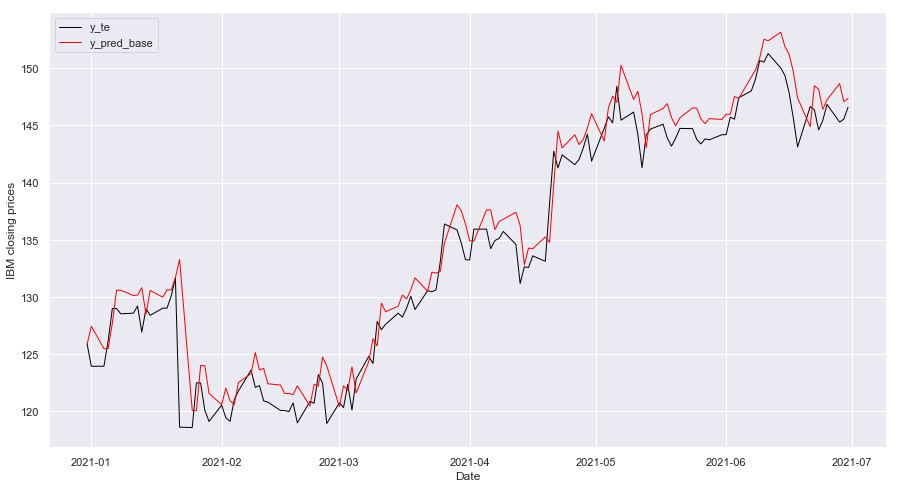

In [202]:
# Show original (blue) and predicted (red) IBM closing price
sns.set(rc={'figure.figsize':(5,5)})
plt.figure(figsize=(15,8))

plt.plot(df_baseline.y_te, marker='', color='black', linewidth=1, alpha=2)
plt.plot(df_baseline.y_pred_base, marker='', color='red', linewidth=1, alpha=2)

plt.ylabel('IBM closing prices')
plt.xlabel('Date')
plt.legend()
plt.show()

The predicted targets of actual stock prices resembles the true curve. It will be challenging to train a model with an even closer curve!

In [203]:
# Baseline MSE of actual prices
MSE_baseline_actual = MSE(df['2020-12-31':'2021-06-30']['IBM_Close'], np.r_[df['2020-12-31':]['IBM_Close'][0], y_pred_base].cumprod())

In [204]:
# Baseline MAE of actual prices
MAE_baseline_actual = MAE(df['2020-12-31':'2021-06-30']['IBM_Close'], np.r_[df['2020-12-31':]['IBM_Close'][0], y_pred_base].cumprod())

---

##### Linear Regression 

In [205]:
# Create a linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(X_tr_rescaled, y_tr)

LinearRegression()

In [206]:
df_lr = pd.DataFrame(zip(features, lr.coef_), columns=['Features', 'Coefficients'])

In [207]:
df_lr.sort_values(by='Coefficients', ascending=True, inplace=True)

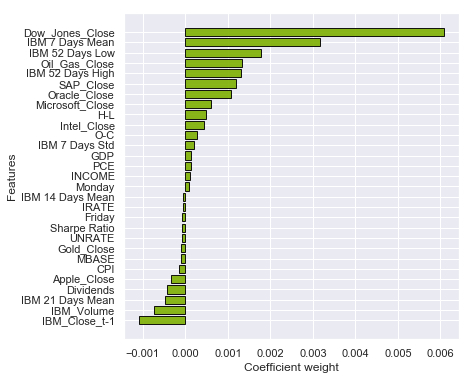

In [208]:
plt.figure(figsize=(6,6))
plt.barh(df_lr.Features, df_lr.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

Some of the coefficients are set around zero, i.e. the respective features are almost not relevant to the model. Remarkable observations: IBM_Close_t-1 has a negative relationship with the target although my assumption was that this feature is really important for predicting single stock prices. 

In [209]:
# R2 cofficient
R2_lr = lr.score(X_te_rescaled, y_te)
print('R2 lr:', R2_lr)

R2 lr: 0.08952587838617243


In [210]:
print('train_MSE:', MSE(y_tr, lr.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, lr.predict(X_te_rescaled)))

train_MSE: 8.637609033337355e-05
test_MSE: 0.0002090861015941056


In [211]:
print('train_MAE:', MAE(y_tr, lr.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, lr.predict(X_te_rescaled)))

train_MAE: 0.006322156122489612
test_MAE: 0.009965448702537193


The $R^2$ coefficients will be used to compare the models at the end of my project since the baseline model does not provide such a coefficient. However the MSE and MAE of the linear regression already improved significantly compared to the baseline model. Let's see if I can further improve by hyperparameter tuning in the next section.

---

*Hypterparameter tuning with L1:*

We usually tune the complexity of the model using grid search. Be aware that I am using the test data set in order to find the best alpha whereas with cross validation the test data set is created in the time series split of the training set.

In [212]:
# Define a set of reasonable values

alpha_ = np.logspace(-10, 10, num=100) # number of alphas in lasso

In [213]:
gs_results = []

# Grid search
for alpha in alpha_: 
    # Create and fit ridge regression
    lasso = Lasso(alpha=alpha, max_iter=1e5)
    lasso.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, lasso.predict(X_tr_rescaled)), 
        'train_mae': MAE(y_tr, lasso.predict(X_tr_rescaled)), 
        'test_mse': MSE(y_te, lasso.predict(X_te_rescaled)),
        'test_mae': MAE(y_te, lasso.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values('test_mae').head()

alpha  test_mae  test_mse  train_mae  train_mse
29  0.000072  0.009900  0.000209   0.006319   0.000087
28  0.000045  0.009904  0.000209   0.006318   0.000086
30  0.000115  0.009911  0.000210   0.006322   0.000087
27  0.000028  0.009925  0.000209   0.006319   0.000086
26  0.000018  0.009939  0.000209   0.006319   0.000086

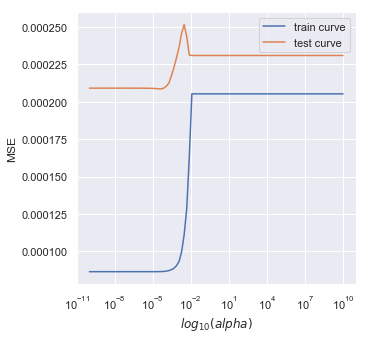

In [214]:
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

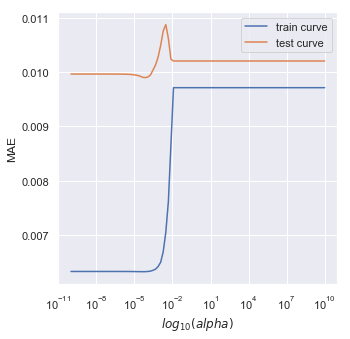

In [215]:
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mae'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

Interpretation of the two plots above:

>- The **optimal** range of alpha values seems to be around 10e-3
>- The model starts **overfitting** when alpha is smaller than 10e-3
    - the test curve does not remain flat when releasing the regularization constraint i.e. alpha values close to zero
>- The models starts **underfitting** when alpha is larger than 10e-3
    -  the performance drops when increasing alpha and the coefficients go to zero

The L1 regularization produces sparse solutions which means that only a few parameters are non-zero. We can verify that by plotting the coefficients of the lasso estimator:

In [216]:
# train lasso with best alpha from grid search

lasso = Lasso(alpha=gs_results.alpha[gs_results.sort_values('test_mae').alpha.index[0]], max_iter=1e5)
lasso.fit(X_tr_rescaled, y_tr)

Lasso(alpha=7.220809018385456e-05, max_iter=100000.0)

In [217]:
# map the features to the coefficients

df_lasso = pd.DataFrame(zip(features, lasso.coef_), columns=['Features', 'Coefficients'])

In [218]:
df_lasso.sort_values(by='Coefficients', ascending=True, inplace=True)

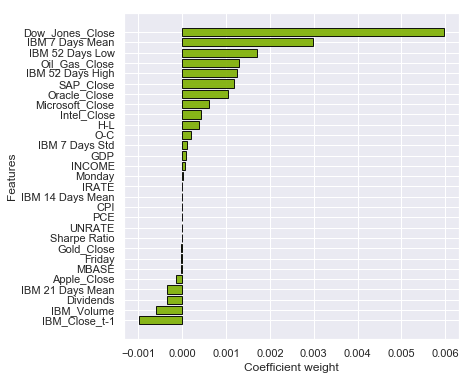

In [219]:
plt.figure(figsize=(6,6))
plt.barh(df_lasso.Features, df_lasso.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

As expected the lasso model makes certain features obsolete.

In [220]:
# R2 cofficient
R2_lasso = lasso.score(X_te_rescaled, y_te)
print('R2 lasso:', R2_lasso)

R2 lasso: 0.08953488103534601


In [221]:
print('train_MSE:', MSE(y_tr, lasso.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, lasso.predict(X_te_rescaled)))

train_MSE: 8.653647816879561e-05
test_MSE: 0.00020908403417804725


In [222]:
print('train_MAE:', MAE(y_tr, lasso.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, lasso.predict(X_te_rescaled)))

train_MAE: 0.006318739774830729
test_MAE: 0.009899681718368764


The performance slightly improved with regards to test_MAE because I tuned the hyperparameters based on this metric. But the test_MSE is slightly worse with hyperparameter tuning. Let's see how cross-validation is impacting the results of grid search in the next section.

---

*Hypterparameter tuning with L1 (incl. CV):*

We usually tune the complexity of the model using grid search **and cross-validation**. By applying the time series split for CV the results cannot be compared 1:1 with the previous model (grid search without CV). The reason is that I am using different training/test data sets (time series split is creating test sets out of the training set instead of using the pre-defined test set). However using the ParameterGrid technique, I can test the 100 combinations by nesting one for loop from above:

In [223]:
# Define a grid of values
grid = ParameterGrid({
    'lasso__alpha': alpha_,
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 100


In [224]:
pipe_lasso = Pipeline([
    ('lasso', Lasso(max_iter=1e5))
])


In [225]:
grid_cv = GridSearchCV(pipe_lasso, grid.param_grid, cv=time_split, scoring='neg_mean_absolute_error')

In [226]:
grid_cv.fit(X_tr_rescaled, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('lasso', Lasso(max_iter=100000.0))]),
             param_grid=[{'lasso__alpha': array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1....
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])}],
             scoring='neg_mean_absolute_error')

In [227]:
print('best parameters {} and best test accuracy: {}'.format(grid_cv.best_params_, grid_cv.best_score_))

best parameters {'lasso__alpha': 0.0004641588833612782} and best test accuracy: -0.00606646800900662


In [228]:
pipe_lasso.set_params(**grid_cv.best_params_) 

pipe_lasso.fit(X_tr_rescaled, y_tr)

Pipeline(steps=[('lasso',
                 Lasso(alpha=0.0004641588833612782, max_iter=100000.0))])

In [229]:
# Collect results in a DataFrame

cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns

cols = ['mean_test_score', 'param_lasso__alpha']
cv_results[cols].sort_values('mean_test_score', ascending=False).head()

mean_test_score param_lasso__alpha
33        -0.006066        0.000464159
32        -0.006076        0.000291505
34        -0.006091        0.000739072
31        -0.006106        0.000183074
30        -0.006135        0.000114976

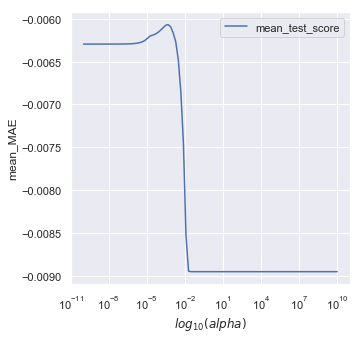

In [230]:
# Plot test curve
plt.semilogx(cv_results['param_lasso__alpha'], cv_results['mean_test_score'])
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('mean_MAE')
plt.legend()
plt.show()

According to the mean test score a low alpha parameter (= high regularization strengths) has the best test accuracy.

The L1 regularization produces sparse solutions which means that only a few parameters are non-zero. We can verify that by plotting the coefficients of the lasso estimator:

In [231]:
df_lasso = pd.DataFrame(zip(features, grid_cv.best_estimator_.named_steps.lasso.coef_), columns=['Features', 'Coefficients'])

In [232]:
df_lasso.sort_values(by='Coefficients', ascending=True, inplace=True)

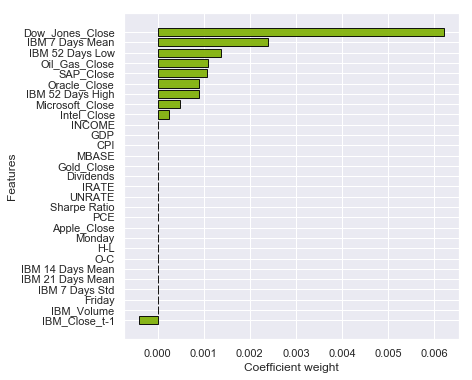

In [233]:
plt.figure(figsize=(6,6))
plt.barh(df_lasso.Features, df_lasso.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

With cross validation the number of features with zero coefficients increased significantly compared to hyperparameter tuning without cross validation.

In [234]:
R2_lasso = grid_cv.best_estimator_.score(X_te_rescaled, y_te)
print('R2 lasso:', R2_lasso)

R2 lasso: 0.02956640627770657


In [235]:
print('train_MSE:', MSE(y_tr, pipe_lasso.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, pipe_lasso.predict(X_te_rescaled)))

train_MSE: 8.860073676718967e-05
test_MSE: 0.00022285551247486535


In [236]:
print('train_MAE:', MAE(y_tr, pipe_lasso.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, pipe_lasso.predict(X_te_rescaled)))

train_MAE: 0.006365137904035293
test_MAE: 0.01013223154874778


In [237]:
MSE_lasso = MSE(y_te, pipe_lasso.predict(X_te_rescaled))

In [238]:
MAE_lasso = MAE(y_te, pipe_lasso.predict(X_te_rescaled))

The test MAE is still much better compared to the baseline model but the CV technique decreased the performance compared to grid search without CV (probably due to the lower training observation due to the time series split). Let's try to improve the performance while tacklling (possible) overfitting with regularization based on the Ridge Regressor.

---

*Hypterparameter tuning with L2 - Ridge regression:*

I replaced the LinearRegression object with a Ridge one. The rest of the code is the same. By default, the Ridge object sets the regularization strength $α$ to one:

In [239]:
gs_results = []

# Grid search
for alpha in alpha_: 
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)), 
        'train_mae': MAE(y_tr, ridge.predict(X_tr_rescaled)), 
        'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
        'test_mae': MAE(y_te, ridge.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values('test_mae').head()

alpha  test_mae  test_mse  train_mae  train_mse
68   5462.277218  0.009319  0.000192   0.006612   0.000096
69   8697.490026  0.009320  0.000193   0.006807   0.000101
67   3430.469286  0.009321  0.000191   0.006495   0.000092
66   2154.434690  0.009335  0.000191   0.006425   0.000090
70  13848.863714  0.009367  0.000196   0.007092   0.000110

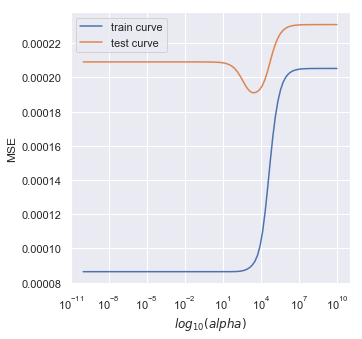

In [240]:
# MSE

plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

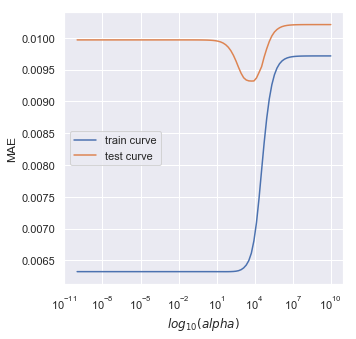

In [241]:
# MAE

plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mae'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

- The **optimal** range of alpha values seems to be around 10e3
- The model starts **overfitting** when alpha is smaller than 10e3
    - the test curve does not remain flat when releasing the regularization constraint i.e. alpha values close to zero
- The models starts **underfitting** when alpha is larger than 10e3
    -  the performance drops when increasing alpha and the coefficients go to zero

In [242]:
# train ridge with best alpha from grid search

ridge = Ridge(alpha=gs_results.alpha[gs_results.sort_values('test_mae').alpha.index[0]])
ridge.fit(X_tr_rescaled, y_tr)

Ridge(alpha=5462.277217684337)

In [243]:
df_ridge = pd.DataFrame(zip(features, ridge.coef_), columns=['Features', 'Coefficients'])

In [244]:
df_ridge.sort_values(by='Coefficients', ascending=True, inplace=True)

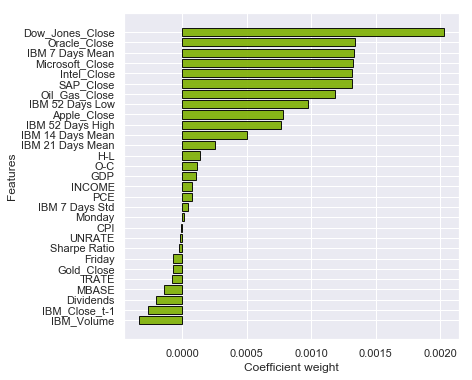

In [245]:
plt.figure(figsize=(6,6))
plt.barh(df_ridge.Features, df_ridge.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

In [246]:
# R2 cofficient

R2_ridge = ridge.score(X_te_rescaled, y_te)
print('R2 ridge:', R2_ridge)

R2 ridge: 0.16494469753795415


In [247]:
print('train_MSE:', MSE(y_tr, ridge.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, ridge.predict(X_te_rescaled)))

train_MSE: 9.588715404399007e-05
test_MSE: 0.000191766524344259


In [248]:
print('train_MAE:', MAE(y_tr, ridge.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, ridge.predict(X_te_rescaled)))

train_MAE: 0.006612053086199076
test_MAE: 0.009318627785471304


---

*Hypterparameter tuning with L2 - Ridge regression (incl. CV):*

We usually tune the complexity of the model using grid search **and cross-validation** - using the ParameterGrid technique, I can test the 100 combinations by nesting one for loop from above:

In [249]:
# Define a grid of values
grid = ParameterGrid({
    'ridge__alpha': alpha_,
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 100


In [250]:
pipe_ridge = Pipeline([
    ('ridge', Ridge())
])


In [251]:
grid_cv = GridSearchCV(pipe_ridge, grid.param_grid, cv=time_split, scoring='neg_mean_absolute_error')

In [252]:
grid_cv.fit(X_tr_rescaled, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid=[{'ridge__alpha': array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
       2.65...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])}],
             scoring='neg_mean_absolute_error')

In [253]:
print('best parameters {} and best test accuracy: {}'.format(grid_cv.best_params_, grid_cv.best_score_))

best parameters {'ridge__alpha': 533.6699231206302} and best test accuracy: -0.006118488275819461


In [254]:
pipe_ridge.set_params(**grid_cv.best_params_) # is equivalent to (as example): pipe.set_params(knn__n_neighbors=1, knn__p=1, knn__weights='uniform');

pipe_ridge.fit(X_tr_rescaled, y_tr)

Pipeline(steps=[('ridge', Ridge(alpha=533.6699231206302))])

In [255]:
# Collect results in a DataFrame

cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns

cols = ['mean_test_score', 'param_ridge__alpha']
cv_results[cols].sort_values('mean_test_score', ascending=False).head()

mean_test_score param_ridge__alpha
63        -0.006118             533.67
64        -0.006122            849.753
62        -0.006130             335.16
61        -0.006147             210.49
65        -0.006151            1353.05

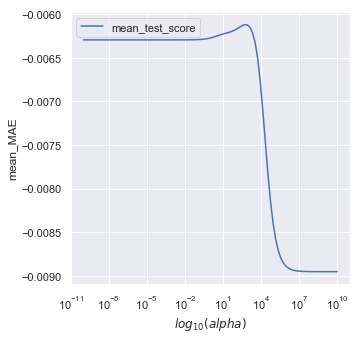

In [256]:
# Plot test curve
plt.semilogx(cv_results['param_ridge__alpha'], cv_results['mean_test_score'])
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('mean_MAE')
plt.legend()
plt.show()

The L2 regularization produces negative results due to the negative MAE set in the scoring parameter. However I can verify the coefficients of the ridge estimator:

In [257]:
df_ridge = pd.DataFrame(zip(features, grid_cv.best_estimator_.named_steps.ridge.coef_), columns=['Features', 'Coefficients'])

In [258]:
df_ridge.sort_values(by='Coefficients', ascending=True, inplace=True)

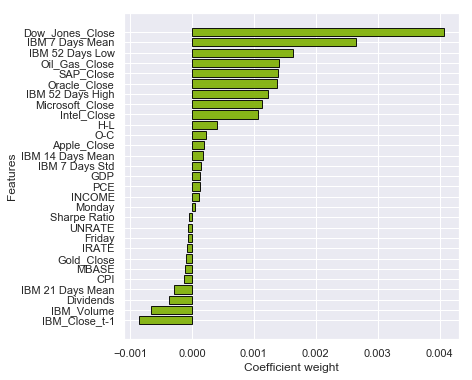

In [259]:
plt.figure(figsize=(6,6))
plt.barh(df_ridge.Features, df_ridge.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

In [260]:
R2_ridge = grid_cv.best_estimator_.score(X_te_rescaled, y_te)
print('R2 ridge:', R2_ridge)

R2 ridge: 0.14603153513602418


In [261]:
print('train_MSE:', MSE(y_tr, pipe_ridge.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, pipe_ridge.predict(X_te_rescaled)))

train_MSE: 8.724834314173457e-05
test_MSE: 0.00019610984317294396


In [262]:
print('train_MAE:', MAE(y_tr, pipe_ridge.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, pipe_ridge.predict(X_te_rescaled)))

train_MAE: 0.0063371674599633524
test_MAE: 0.009534277191217211


In [263]:
MSE_ridge = MSE(y_te, pipe_ridge.predict(X_te_rescaled))

In [264]:
MAE_ridge = MAE(y_te, pipe_ridge.predict(X_te_rescaled))

$R^2$ of the tuned Ridge model without CV is the highest of all Linear Regression models. Again the performance with regards to MAE is worse for the tuned Ridge model with CV due to the same reason as seen with the lasso model. However the test MAE is better for tuned Ridge model with CV than the tuned Lasso model with CV. 

---

In [265]:
# Revert predicted target values

y_pred_lasso = pipe_lasso.predict(X_te_rescaled)
y_pred_ridge = pipe_ridge.predict(X_te_rescaled)

In [266]:
for i in range(len(y_pred_lasso)):
    y_pred_lasso[i] = 1+y_pred_lasso[i]

In [267]:
for i in range(len(y_pred_ridge)):
    y_pred_ridge[i] = 1+y_pred_ridge[i]

In [268]:
df_lasso_ridge = pd.DataFrame({'y_te': df['2021-01-01':'2021-06-30']['IBM_Close'], 'y_pred_lasso': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_lasso[1:]].cumprod(), 'y_pred_ridge': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_ridge[1:]].cumprod()})

In [269]:
# Lasso MSE of actual prices
MSE_lasso_actual = MSE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_lasso[1:]].cumprod())

# Ridge MSE of actual prices
MSE_ridge_actual = MSE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_ridge[1:]].cumprod())

In [270]:
# Lasso MAE of actual prices
MAE_lasso_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_lasso[1:]].cumprod())

# Ridge MAE of actual prices
MAE_ridge_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_ridge[1:]].cumprod())

---

##### k-Nearest Neighbours

Going forward I will apply grid search with cross validation only for a better readability. 

*Hypterparameter tuning with k values and distances (incl. CV):*

We usually tune the complexity of the model using grid search **and cross-validation** - using the ParameterGrid technique, I can test the 40 combinations by nesting two for loops:

In [271]:
# Define a set of reasonable values

n_neighbors = np.arange(1,101, 5)
p = [1, 2]

In [272]:
# Define a grid of values

grid = ParameterGrid({
    'knn__n_neighbors': n_neighbors,
    'knn__p': p,
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 40


In [273]:
pipe_kNN = Pipeline([
    ('knn', KNeighborsRegressor())
])


In [274]:
grid_cv = GridSearchCV(pipe_kNN, grid.param_grid, cv=time_split, scoring='neg_mean_absolute_error')

In [275]:
grid_cv.fit(X_tr_rescaled, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('knn', KNeighborsRegressor())]),
             param_grid=[{'knn__n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
                          'knn__p': [1, 2]}],
             scoring='neg_mean_absolute_error')

In [276]:
print('best parameters {} and best test accuracy: {}'.format(grid_cv.best_params_, grid_cv.best_score_))

best parameters {'knn__n_neighbors': 11, 'knn__p': 1} and best test accuracy: -0.00608027327464308


In [277]:
pipe_kNN.set_params(**grid_cv.best_params_) # is equivalent to (as example): pipe.set_params(knn__n_neighbors=1, knn__p=1, knn__weights='uniform');

pipe_kNN.fit(X_tr_rescaled, y_tr)

Pipeline(steps=[('knn', KNeighborsRegressor(n_neighbors=11, p=1))])

In [278]:
# Collect results in a DataFrame

cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns

cols = ['mean_test_score', 'param_knn__n_neighbors', 'param_knn__p']
cv_results[cols].sort_values('mean_test_score', ascending=False).head()

mean_test_score param_knn__n_neighbors param_knn__p
4        -0.006080                     11            1
2        -0.006119                      6            1
6        -0.006144                     16            1
8        -0.006220                     21            1
5        -0.006284                     11            2

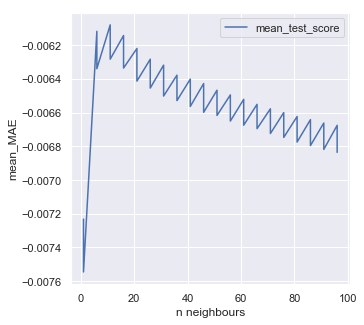

In [279]:
# Plot test curve
plt.plot(cv_results['param_knn__n_neighbors'], cv_results['mean_test_score'])
plt.xlabel('n neighbours')
plt.ylabel('mean_MAE')
plt.legend()
plt.show()

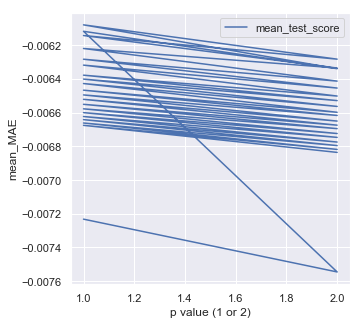

In [280]:
# Plot test curve
plt.plot(cv_results['param_knn__p'], cv_results['mean_test_score'])
plt.xlabel('p value (1 or 2)')
plt.ylabel('mean_MAE')
plt.legend()
plt.show()

In [281]:
R2_knn = grid_cv.best_estimator_.score(X_te_rescaled, y_te)
print('R2 kNN:', R2_knn)

R2 kNN: 0.40958579923110006


In [282]:
print('train_MSE:', MSE(y_tr, pipe_kNN.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, pipe_kNN.predict(X_te_rescaled)))

train_MSE: 6.909920193736929e-05
test_MSE: 0.000135585845477691


In [283]:
print('train_MAE:', MAE(y_tr, pipe_kNN.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, pipe_kNN.predict(X_te_rescaled)))

train_MAE: 0.005642051956177567
test_MAE: 0.008107247298979072


In [284]:
MSE_kNN = MSE(y_te, pipe_kNN.predict(X_te_rescaled))

In [285]:
MAE_kNN = MAE(y_te, pipe_kNN.predict(X_te_rescaled))

The predictions for both the training and test sets have improved compared to the linear regression models (tuned lasso/ridge with CV). The $R^2$ coefficient is much better as well. 

In [286]:
# Revert predicted target values

y_pred_kNN = pipe_kNN.predict(X_te_rescaled)

In [287]:
for i in range(len(y_pred_kNN)):
    y_pred_kNN[i] = 1+y_pred_kNN[i]

In [288]:
df_kNN = pd.DataFrame({'y_te': df['2021-01-01':'2021-06-30']['IBM_Close'], 'y_pred_kNN': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_kNN[1:]].cumprod()})

In [289]:
# kNN MSE of actual prices
MSE_kNN_actual = MSE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_kNN[1:]].cumprod())

In [290]:
# kNN MAE of actual prices
MAE_kNN_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_kNN[1:]].cumprod())

---

##### Random Forest

We usually tune the complexity of the model using grid search **and cross-validation** - using the ParameterGrid technique, I can test the 15 combinations by nesting two for loops:

In [291]:
# Define a set of reasonable values

n_estimators = [5, 10, 30, 100, 200] # number of trees in the foreset
max_depth = [80, 90, None] # max number of levels in each decision tree

In [292]:
# Define a grid of values

grid = ParameterGrid({
    'rf__n_estimators': n_estimators,
    'rf__max_depth': max_depth,
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 15


In [293]:
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=0, n_jobs=-1))
])

In [294]:
grid_cv = GridSearchCV(pipe_rf, grid.param_grid, cv=time_split, scoring='neg_mean_absolute_error')

In [295]:
grid_cv.fit(X_tr_rescaled, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=0))]),
             param_grid=[{'rf__max_depth': [80, 90, None],
                          'rf__n_estimators': [5, 10, 30, 100, 200]}],
             scoring='neg_mean_absolute_error')

In [296]:
print('best parameters {} and best test accuracy: {}'.format(grid_cv.best_params_, grid_cv.best_score_))

best parameters {'rf__max_depth': None, 'rf__n_estimators': 200} and best test accuracy: -0.004988155818158937


In [297]:
pipe_rf.set_params(**grid_cv.best_params_) # is equivalent to (as example): pipe.set_params(knn__n_neighbors=1, knn__p=1, knn__weights='uniform');

pipe_rf.fit(X_tr_rescaled, y_tr)

Pipeline(steps=[('rf',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=0))])

In [298]:
# Collect results in a DataFrame

cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns

cols = ['mean_test_score', 'param_rf__n_estimators', 'param_rf__max_depth']
cv_results[cols].sort_values('mean_test_score', ascending=False).head()

mean_test_score param_rf__n_estimators param_rf__max_depth
14        -0.004988                    200                None
4         -0.004988                    200                  80
9         -0.004988                    200                  90
3         -0.005014                    100                  80
8         -0.005014                    100                  90

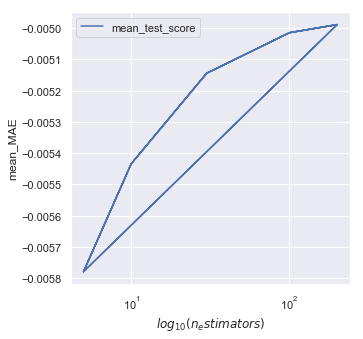

In [299]:
# Plot test curve
plt.semilogx(cv_results['param_rf__n_estimators'], cv_results['mean_test_score'])
plt.xlabel('$log_{10}(n_estimators)$')
plt.ylabel('mean_MAE')
plt.legend()
plt.show()

The test score gets clearly better with a higher amount of trees.

A model is especially useful if insights can be extracted from it so as to drive the decision-making process.
In continuation of the random forest model built above, important features stored in the instantiated rf model can be extracted:

In [300]:
df_rf_features = pd.DataFrame(zip(features, pipe_rf.named_steps.rf.feature_importances_), columns=['Features', 'Gini'])

In [301]:
df_rf_features.sort_values(by='Gini', ascending=True, inplace=True)

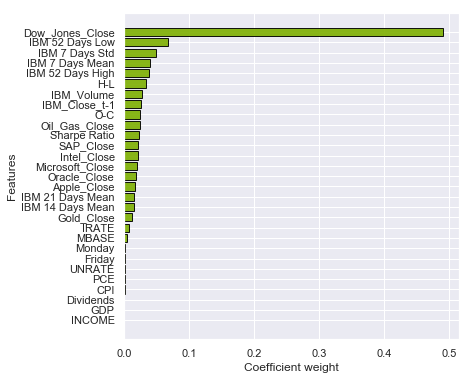

In [302]:
plt.figure(figsize=(6,6))
plt.barh(df_rf_features.Features, df_rf_features.Gini, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

In a nutshell, as the name implies a feature importance plot provides the relative importance of features (the higher, the more important the feature). In this case the IBM stock price 

In [303]:
R2_rf = grid_cv.best_estimator_.score(X_te_rescaled, y_te)
print('R2 kNN:', R2_rf)

R2 kNN: 0.3614496906284268


In [304]:
print('train_MSE:', MSE(y_tr, pipe_rf.predict(X_tr_rescaled)))
print('test_MSE:', MSE(y_te, pipe_rf.predict(X_te_rescaled)))

train_MSE: 8.508369808798802e-06
test_MSE: 0.00014664007651481677


In [305]:
print('train_MAE:', MAE(y_tr, pipe_rf.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, pipe_rf.predict(X_te_rescaled)))

train_MAE: 0.001847420275961224
test_MAE: 0.008143054037776012


The test MAE is slightly worse compared to the kNN model but the train MAE is much better for the rf model. This might be an indication for an overfitted rf model because the predictions on the training set is quite precise but relatively bad on generalization. 

In [306]:
MSE_rf = MSE(y_te, pipe_rf.predict(X_te_rescaled))

In [307]:
MAE_rf = MAE(y_te, pipe_rf.predict(X_te_rescaled))

In [308]:
# Revert predicted target values

y_pred_rf = pipe_rf.predict(X_te_rescaled)

In [309]:
for i in range(len(y_pred_rf)):
    y_pred_rf[i] = 1+y_pred_rf[i]

In [310]:
df_rf = pd.DataFrame({'y_te': df['2021-01-01':'2021-06-30']['IBM_Close'], 'y_pred_rf': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_rf[1:]].cumprod()})

In [311]:
# Rf MSE of actual prices
MSE_rf_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_rf[1:]].cumprod())

In [312]:
# Rf MAE of actual prices
MAE_rf_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_rf[1:]].cumprod())

---

##### Artificial Neural Network

I am creating an additional validation set since my artificial neural networks will not be finetuned with GridSearchCV:

In [313]:
# corona crisis dropped

df_train_NN = df_eng['2001':'2018']

In [314]:
df_valid_NN = df_eng['2019']

In [315]:
# only Q1 and Q2

df_test_NN = df_eng['2021'][df_eng['2021'].index.quarter != 3]

In [316]:
X_tr_NN = df_train_NN.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).values

In [317]:
X_va_NN = df_valid_NN.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).values

In [318]:
X_te_NN = df_test_NN.drop(['IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close'],axis=1).values

In [319]:
y_tr_NN = df_train_NN.IBM_Close.values

In [320]:
y_va_NN = df_valid_NN.IBM_Close.values

In [321]:
y_te_NN = df_test_NN.IBM_Close.values

In [322]:
X_tr_NN_rescaled = scaler.fit_transform(X_tr_NN)
X_va_NN_rescaled = scaler.transform(X_va_NN)
X_te_NN_rescaled = scaler.transform(X_te_NN)

Let's create artificial neural networks from scratch and use batches of data examples to reduce memory usage:

- 1-layer dense network i.e. no hidden layer, just the input and output ones

In [323]:
model_1 = Sequential()
model_1.add(Dense(
    units=1, activation=activations.linear, input_dim=X_tr_NN.shape[1],
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [324]:
# Define optimizer, loss function and metrics to track during training

model_1.compile(
    optimizer='Adam', # takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training: Adam algorithm (stochastic gradient descent method)
    loss='mean_absolute_error', # a loss function is any callable with the signature loss = fn(y_true,y_pred)
    metrics= ['mse'] # metrics to be evaluated by the model during training and testing
)

In [325]:
# End training when MAE stops improving (optional)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [326]:
# Fit model
history = model_1.fit(
    x=X_tr_NN_rescaled, y=y_tr_NN,
    batch_size=32, epochs=50, validation_data=(X_va_NN_rescaled, y_va_NN), callbacks=[early_stopping],
    shuffle=False # don't shuffle training samples due to time series data
)

Train on 4644 samples, validate on 261 samples
Epoch 1/50
4644/4644 [==============================] - 0s 41us/step - loss: 0.6889 - mean_squared_error: 1.0018 - val_loss: 0.5044 - val_mean_squared_error: 0.7042
Epoch 2/50
4644/4644 [==============================] - 0s 14us/step - loss: 0.4149 - mean_squared_error: 0.4276 - val_loss: 0.2803 - val_mean_squared_error: 0.3044
Epoch 3/50
4644/4644 [==============================] - 0s 14us/step - loss: 0.2154 - mean_squared_error: 0.1625 - val_loss: 0.1380 - val_mean_squared_error: 0.1200
Epoch 4/50
4644/4644 [==============================] - 0s 16us/step - loss: 0.1024 - mean_squared_error: 0.0622 - val_loss: 0.0655 - val_mean_squared_error: 0.0398
Epoch 5/50
4644/4644 [==============================] - 0s 16us/step - loss: 0.0443 - mean_squared_error: 0.0235 - val_loss: 0.0194 - val_mean_squared_error: 0.0079
Epoch 6/50
4644/4644 [==============================] - 0s 15us/step - loss: 0.0161 - mean_squared_error: 0.0087 - val_loss: 0.0

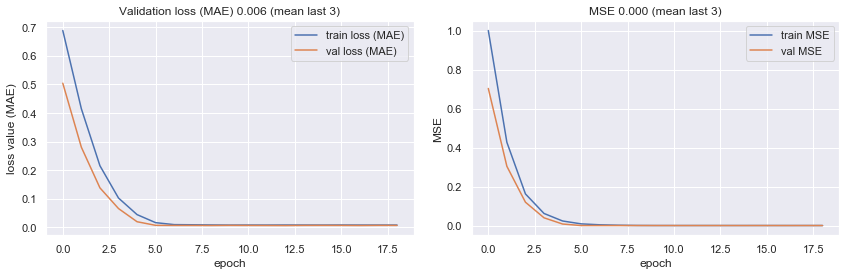

In [327]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot MAE values
ax1.plot(history.history['loss'], label='train loss (MAE)')
ax1.plot(history.history['val_loss'], label='val loss (MAE)')
ax1.set_title('Validation loss (MAE) {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value (MAE)')
ax1.legend()

# Plot MSE values
ax2.plot(history.history['mean_squared_error'], label='train MSE')
ax2.plot(history.history['val_mean_squared_error'], label='val MSE')
ax2.set_title('MSE {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_mean_squared_error'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('MSE')
ax2.legend()


plt.tight_layout()
plt.show()

We can see that the validation loss and accuracy reach a plateau after 5 epochs.

In [328]:
layer = model_1.layers[0]

In [329]:
weights, biases = layer.get_weights()

In [330]:
df_model_1 = pd.DataFrame(zip(features, weights), columns=['Features', 'Coefficients'])

In [331]:
df_model_1.sort_values(by='Coefficients', ascending=True, inplace=True)

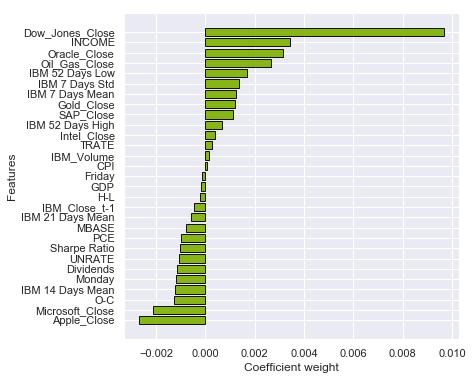

In [332]:
plt.figure(figsize=(6,6))
plt.barh(df_model_1.Features, df_model_1.Coefficients, color='#7CAE00', edgecolor='black', alpha=0.9)
plt.ylabel('Features')
plt.xlabel('Coefficient weight')
plt.show();

In [333]:
R2_NN_1 = r2_score(y_te_NN, model_1.predict(X_te_NN_rescaled))
print('R2 NN_1:', R2_NN_1)

R2 NN_1: 0.026005946284245796


In [334]:
print('train_MSE:', MSE(y_tr_NN, model_1.predict(X_tr_NN_rescaled)))
print('test_MSE:', MSE(y_te_NN, model_1.predict(X_te_NN_rescaled)))

train_MSE: 0.00012746428503698952
test_MSE: 0.000223673155373485


In [335]:
print('train_MAE:', MAE(y_tr, model_1.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, model_1.predict(X_te_rescaled)))

train_MAE: 0.007582019396855205
test_MAE: 0.00972664455811661


The performance is not overwhelming and could probably be tuned with GridSearchCV. So far, I created networks with a single layer of neurons which are
equivalent to linear regressions. Let's see if a network with a single hidden layer is more powerful in the section. 

In [336]:
MSE_NN_1 = MSE(y_te, model_1.predict(X_te_rescaled))

In [337]:
MAE_NN_1 = MAE(y_te, model_1.predict(X_te_rescaled))

---

- 2-layer dense network i.e. one hidden layer:

In [338]:
# Create model
model_2 = Sequential()

# First hidden layer
model_2.add(Dense(
    units=50, activation=activations.linear, input_dim=X_tr_NN.shape[1],
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))

# Second hidden layer = output layer
model_2.add(Dense(
    units=1, activation=activations.linear,
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))

# Print network summary
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1500      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
_________________________________________________________________


In [339]:
# Define optimizer, loss function and metrics to track during training

model_2.compile(
    optimizer='Adam', # takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training: Adam algorithm (stochastic gradient descent method)
    loss='mean_absolute_error', # a loss function is any callable with the signature loss = fn(y_true,y_pred)
    metrics= ['mse'] # metrics to be evaluated by the model during training and testing
)

In [340]:
# Fit model
history_2 = model_2.fit(
    x=X_tr_NN_rescaled, y=y_tr_NN,
    batch_size=32, epochs=50, validation_data=(X_va_NN_rescaled, y_va_NN), callbacks=[early_stopping],
    shuffle=False # don't shuffle training samples due to time series data
)

Train on 4644 samples, validate on 261 samples
Epoch 1/50
4644/4644 [==============================] - 0s 64us/step - loss: 1.2683 - mean_squared_error: 4.0998 - val_loss: 0.7093 - val_mean_squared_error: 1.0204
Epoch 2/50
4644/4644 [==============================] - 0s 21us/step - loss: 0.3939 - mean_squared_error: 0.4232 - val_loss: 0.1617 - val_mean_squared_error: 0.0510
Epoch 3/50
4644/4644 [==============================] - 0s 27us/step - loss: 0.0479 - mean_squared_error: 0.0120 - val_loss: 0.0200 - val_mean_squared_error: 9.8577e-04
Epoch 4/50
4644/4644 [==============================] - 0s 30us/step - loss: 0.0154 - mean_squared_error: 0.0011 - val_loss: 0.0158 - val_mean_squared_error: 0.0013
Epoch 5/50
4644/4644 [==============================] - 0s 49us/step - loss: 0.0162 - mean_squared_error: 9.2352e-04 - val_loss: 0.0154 - val_mean_squared_error: 0.0014
Epoch 6/50
4644/4644 [==============================] - 0s 40us/step - loss: 0.0159 - mean_squared_error: 0.0012 - val_l

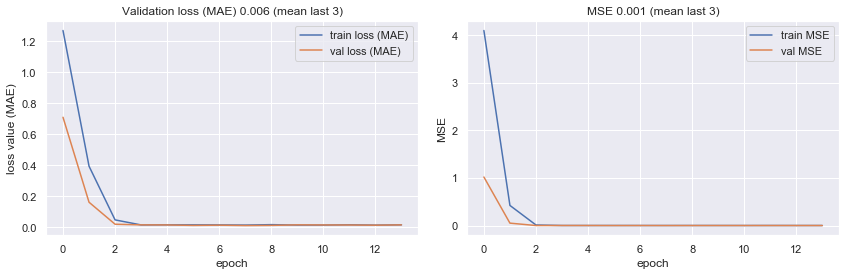

In [341]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot MAE values
ax1.plot(history_2.history['loss'], label='train loss (MAE)')
ax1.plot(history_2.history['val_loss'], label='val loss (MAE)')
ax1.set_title('Validation loss (MAE) {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value (MAE)')
ax1.legend()

# Plot MSE values
ax2.plot(history_2.history['mean_squared_error'], label='train MSE')
ax2.plot(history_2.history['val_mean_squared_error'], label='val MSE')
ax2.set_title('MSE {:.3f} (mean last 3)'.format(
    np.mean(history_2.history['val_mean_squared_error'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('MSE')
ax2.legend()


plt.tight_layout()
plt.show()

We can see that the validation loss and accuracy reach a plateau after 2 epochs.

In [342]:
R2_NN_2 = r2_score(y_te_NN, model_2.predict(X_te_NN_rescaled))
print('R2 kNN:', R2_NN_2)

R2 kNN: -2.535289619316987


In [343]:
print('train_MSE:', MSE(y_tr_NN, model_2.predict(X_tr_NN_rescaled)))
print('test_MSE:', MSE(y_te_NN, model_2.predict(X_te_NN_rescaled)))

train_MSE: 0.0006999778437873414
test_MSE: 0.000811862640531608


In [344]:
print('train_MAE:', MAE(y_tr, model_2.predict(X_tr_rescaled)))
print('test_MAE:', MAE(y_te, model_2.predict(X_te_rescaled)))

train_MAE: 0.017119927993568977
test_MAE: 0.01860443556263615


In [345]:
MSE_NN_2 = MSE(y_te, model_2.predict(X_te_rescaled))

In [346]:
MAE_NN_2 = MAE(y_te, model_2.predict(X_te_rescaled))

The performance is slightly better compared to a one layer network. Reminder: the ANN models use different training sets compared to the previous models and tuning of parameters did not take place with GridSeachCV! Therefore I cannot directly compare the performance with other models used in this project. 

In [347]:
# Revert predicted target values

y_te_NN = y_te_NN.copy()
y_pred_NN_1 = model_1.predict(X_te_rescaled).flatten()
y_pred_NN_2 = model_2.predict(X_te_rescaled).flatten()

In [348]:
for i in range(len(y_te_NN)):
    y_te_NN[i] = 1+y_te_NN[i]

In [349]:
for i in range(len(y_pred_NN_1)):
    y_pred_NN_1[i] = 1+y_pred_NN_1[i]

In [350]:
for i in range(len(y_pred_NN_2)):
    y_pred_NN_2[i] = 1+y_pred_NN_2[i]

In [351]:
df_NN = pd.DataFrame({'y_te_NN': df['2021-01-01':'2021-06-30']['IBM_Close'], 'y_pred_NN_1': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_1[1:]].cumprod(), 'y_pred_NN_2': np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_2[1:]].cumprod()})

In [352]:
# 1-layer dense network MSE of actual prices
MSE_NN_1_actual = MSE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_1[1:]].cumprod())

In [353]:
# 2-layer dense network MSE of actual prices
MSE_NN_2_actual = MSE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_2[1:]].cumprod())

In [354]:
# 1-layer dense network MAE of actual prices
MAE_NN_1_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_1[1:]].cumprod())

In [355]:
# 2-layer dense network MAE of actual prices
MAE_NN_2_actual = MAE(df['2021-01-01':'2021-06-30']['IBM_Close'], np.r_[df['2021-01-01':]['IBM_Close'][0], y_pred_NN_2[1:]].cumprod())

---

##### Final Discussion

Let's have an overall view on the metrics including visualizations:

- Scatterplots for target and predicted target
- Actual target price chart
- $R^2$ coefficient
- Actual vs pct_change(1) MSE/ MAE

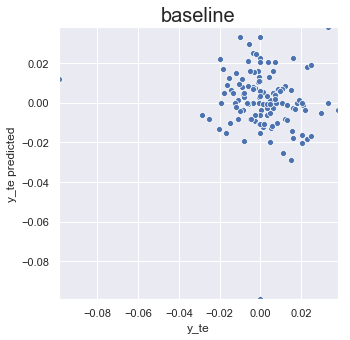

In [356]:
# baseline model

sns.scatterplot(y_te, y_pred)
sns.set(rc={'figure.figsize':(5,5)})
plt.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
plt.xlabel('y_te')
plt.ylabel('y_te predicted')
plt.ylim(min(y_pred), max(y_pred))
plt.xlim(min(y_te), max(y_te))
plt.title('baseline',fontsize=20)
plt.show;

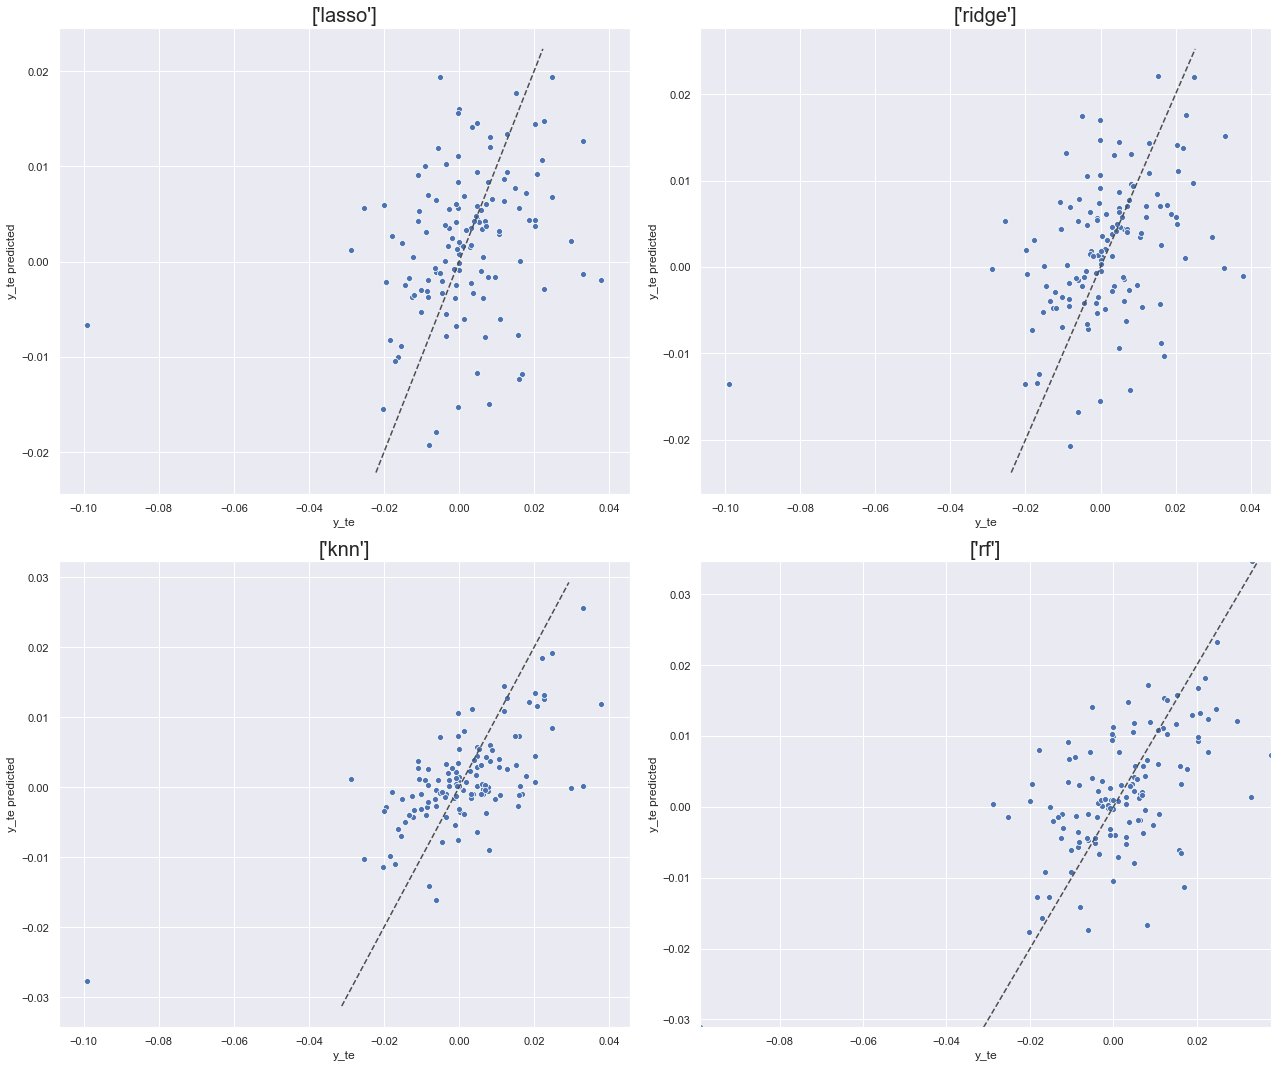

In [357]:
# all models except for neural networks

fig,axes = plt.subplots(2,2,figsize=(18,15))

for pipe,ax in zip([pipe_lasso, pipe_ridge, pipe_kNN, pipe_rf],axes.ravel()):
    sns.scatterplot(y_te, pipe.predict(X_te_rescaled), ax=ax)
    sns.set(rc={'figure.figsize':(5,5)})
    ax.set_ylabel('y_te predicted')
    ax.set_xlabel('y_te')
    ax.set_title([pipe.steps[0][0]])
    ax.title.set_size(20)

    plt.ylim(min(pipe.predict(X_te_rescaled)), max(pipe.predict(X_te_rescaled)))
    plt.xlim(min(y_te), max(y_te))
    
    ax.plot(ax.get_ylim(), ax.get_ylim(), ls="--", c=".3")

plt.tight_layout();

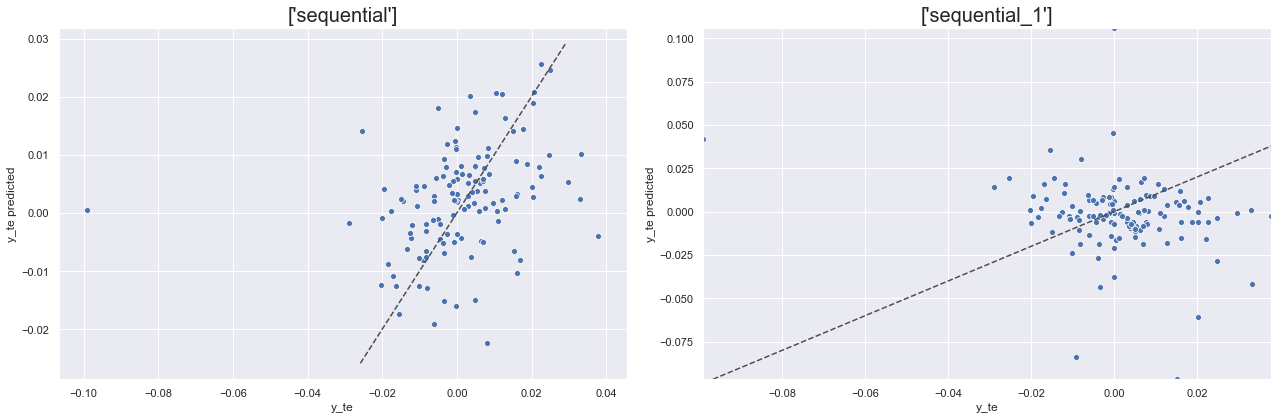

In [358]:
# neural networks (first sequential on the left side = 1-layer NN; second sequential on the right side = 2-layer NN)

fig,axes = plt.subplots(1,2,figsize=(18,6))

for model,ax in zip([model_1, model_2],axes.ravel()):
    sns.scatterplot(y_te, model.predict(X_te_rescaled).flatten(), ax=ax)
    sns.set(rc={'figure.figsize':(5,5)})
    ax.set_ylabel('y_te predicted')
    ax.set_xlabel('y_te')
    ax.set_title([model.name])
    ax.title.set_size(20)


    plt.ylim(min(model.predict(X_te_rescaled).flatten()), max(model.predict(X_te_rescaled).flatten()))
    plt.xlim(min(y_te), max(y_te))
    
    ax.plot(ax.get_ylim(), ax.get_ylim(), ls="--", c=".3")

plt.tight_layout();

**Findings:** In a perfect world all points would lie on the black line. The more they differ, the higher is the difference between a predicted target it's true value. Although the scatterplots are not easy to interpret I spot the points of kNN are less distributed compared to the remaining models.

---

Let's plot the actual targets of all models:

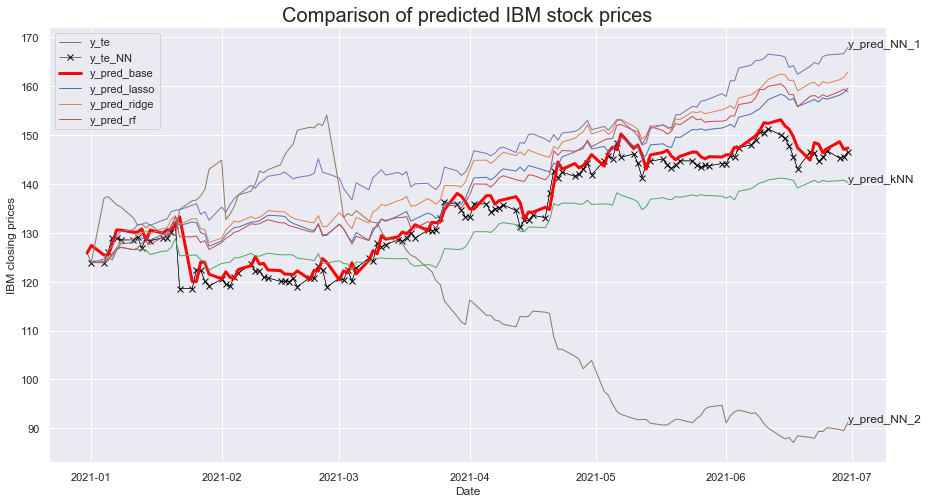

In [359]:
# Show original (black) and predicted (see colors legend) IBM closing price

plt.figure(figsize=(15,8))

plt.plot(df_baseline.y_te, marker='', color='black', linewidth=0.5, alpha=5)

plt.plot(df_NN.y_te_NN, marker='x', color='black', linewidth=0.5, alpha=5)

plt.plot(df_baseline.y_pred_base, marker='', color='red', linewidth=3, alpha=5)

plt.plot(df_lasso_ridge.y_pred_lasso, linewidth=1)

plt.plot(df_lasso_ridge.y_pred_ridge, linewidth=1)

plt.plot(df_kNN.y_pred_kNN, linewidth=1, label='_nolegend_')
plt.annotate('y_pred_kNN',xy=(df_kNN.index[-1],df_kNN.tail(1)['y_pred_kNN']))

plt.plot(df_rf.y_pred_rf, linewidth=1)

plt.plot(df_NN.y_pred_NN_1, linewidth=1, label='_nolegend_')
plt.annotate('y_pred_NN_1',xy=(df_NN.index[-1],df_NN.tail(1)['y_pred_NN_1']))

plt.plot(df_NN.y_pred_NN_2, linewidth=1, label='_nolegend_')
plt.annotate('y_pred_NN_2',xy=(df_NN.index[-1],df_NN.tail(1)['y_pred_NN_2']))

plt.ylabel('IBM closing prices')
plt.xlabel('Date')
plt.title('Comparison of predicted IBM stock prices', fontsize=20)
plt.legend()
plt.show()

**Findings:** As I had already feared the baseline model is actually the closest one to the true curve in terms of actual closing prices. 

---

I drop the neural networks $R^2$ coefficients because the models completely failed to recreate dependent variables (high negative score).

In [360]:
R2_coefficients = pd.DataFrame([R2_lasso, R2_ridge, R2_knn, R2_rf], ['lasso', 'ridge', 'knn', 'rf'], columns=['R2 Coefficient']).sort_values('R2 Coefficient')

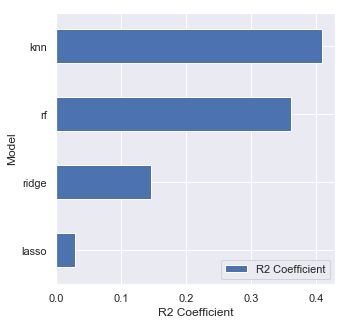

In [361]:
R2_coefficients.plot(kind='barh')
plt.ylabel('Model')
plt.xlabel('R2 Coefficient')
plt.show();

kNN achieved the highest coefficients, i.e. how well the regression model fits the observed data. However I need to check the other metrics as well for a final conclusion.

---

In [362]:
MSE_all = pd.DataFrame({'Model': ['lasso', 'ridge','kNN','rf', 'NN_1', 'NN_2', 'baseline'], 'pct_change(1) MSE': [MSE_lasso,MSE_ridge, MSE_kNN, MSE_rf, MSE_NN_1, MSE_NN_2,MSE_baseline], 'Actual MSE': [MSE_lasso_actual,MSE_ridge_actual, MSE_kNN_actual, MSE_rf_actual, MSE_NN_1_actual, MSE_NN_2_actual,MSE_baseline_actual]}).sort_values('Actual MSE')

In [363]:
MSE_all.set_index('Model', inplace=True)

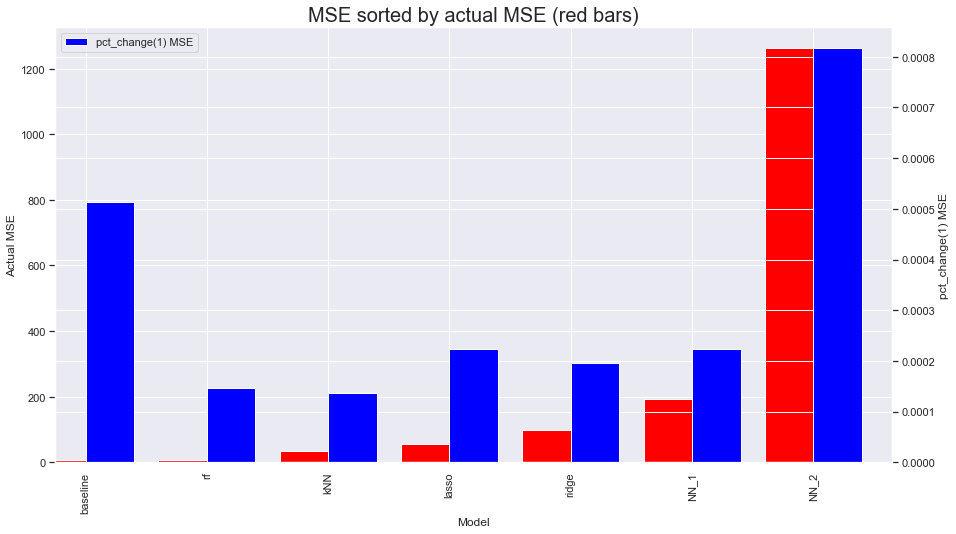

In [364]:
fig = plt.figure(figsize=(15,8)) 

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

MSE_all['Actual MSE'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
MSE_all['pct_change(1) MSE'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Actual MSE')
ax2.set_ylabel('pct_change(1) MSE')

plt.title('MSE sorted by actual MSE (red bars)', fontsize=20)
plt.legend()
plt.show();

In [365]:
MAE_all = pd.DataFrame({'Model': ['lasso', 'ridge','kNN','rf', 'NN_1', 'NN_2', 'baseline'], 'pct_change(1) MAE': [MAE_lasso,MAE_ridge, MAE_kNN, MAE_rf, MAE_NN_1, MAE_NN_2,MAE_baseline], 'Actual MAE': [MAE_lasso_actual,MAE_ridge_actual, MAE_kNN_actual, MAE_rf_actual, MAE_NN_1_actual, MAE_NN_2_actual,MAE_baseline_actual]}).sort_values('Actual MAE')

In [366]:
MAE_all.set_index('Model', inplace=True)

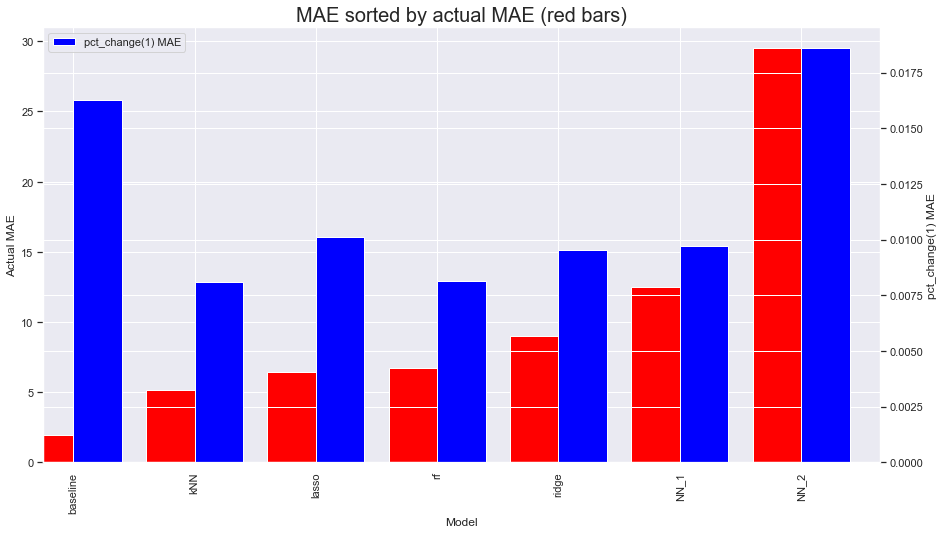

In [367]:
fig = plt.figure(figsize=(15,8)) 

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

MAE_all['Actual MAE'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
MAE_all['pct_change(1) MAE'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Actual MAE')
ax2.set_ylabel('pct_change(1) MAE')

plt.title('MAE sorted by actual MAE (red bars)', fontsize=20)
plt.legend()
plt.show();

**Findings:** 
> MSE: The baseline model wins when it comes to actual MSE but ranks as the worst model with regards to pct_change(1) MSE. One has to keep in mind that both neural network models have neither been trained with grid search nor with cross validation. kNN is in top 3 for both metrics. 


> MAE: Same as MSE and kNN is still in top 3 for both metrics.

The big question is why the pct_change(1) MSE/ MAE of the baseline model is the worst of all but the price chart of the baseline is much closer to the true stock price. One reason could be the big drops(e.g. in Jan 2021): at this point the trained models MSE/ MAE get a huge error for once due to this unusual movement. But going forward their price movements resembles very much the real price movements. Therefore overall the pct_change(1) MSE/ MAE is relatively low compared to the baseline model. However when I look at the actual MAE the baseline model's performance is the best because the actual price difference is lower (the baseline can react better since the predicted target is the target from the previous day). 

For example the Random Forest scatterplot clearly shows that my model predict a much lower pct_change of -0.03 when the true target dropped by -0.10:

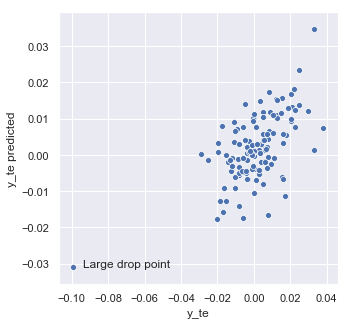

In [368]:
sns.scatterplot(y_te, pipe_rf.predict(X_te_rescaled))
sns.set(rc={'figure.figsize':(5,5)})

plt.xlabel('y_te')
plt.ylabel('y_te predicted')

plt.annotate('Large drop point',
             xy=(y_te[y_te<  -0.05], 
             pipe_rf.predict(X_te_rescaled)[pipe_rf.predict(X_te_rescaled) < -0.02]),
             xytext = (y_te[y_te<  -0.05]+0.005, 
             pipe_rf.predict(X_te_rescaled)[pipe_rf.predict(X_te_rescaled) < -0.02])
            )

plt.show;

**Final conclusion:** Apart from the baseline model I conclude that kNN has the best performance for predicting the IBM closing stock price. However since IBM_Close_t-1 is a feature in my models which are trained without memorization, this feature is not getting the proper weights. Therefore all models disregards heavy upward and downward changes of the stock prices whereas the baseline model can immediately react with it's predicted target IBM_Close_t-1. For example if I used the Long-Short-Term-Memory (LSTM) model I would definitively get better results compared to my baseline model.